# Analyses for the Literature Contextizer Project

Author: Dan Sosa

Updated: 11/07/22

#### Test the CLI

In [1]:
# !/Users/dnsosa/opt/miniconda3/envs/lit_con2/bin/python -m lit_contextizer --no_parse_files --pmc_query_list_path /Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/papers_to_extract_features_from.csv --output_folder /Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/notebooks/jake_papers


## Cell Type Context-PPI Association

First, let's load what we need from the `lit_contextizer` package.

In [1]:
# General imports
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Improt from lit_contextizer
from lit_contextizer.classifiers.AnalysisUtilities import include_annotations_in_insider_corpus
from lit_contextizer.data_models.DataLoader import DataLoader
from lit_contextizer.data_models.DataLoaderUtilities import create_dengue_corpus
from lit_contextizer.data_models.PaperUtilities import extract_features
from lit_contextizer.data_models.Utilities import load_all_groundings
from lit_contextizer.classifiers.VisualizationUtilities import draw_CTs_in_mesh_counts, draw_section_distribution, generate_analysis_figs, plot_benchmark_fig, plot_con_mention_frac_precision_plots

# Pandas configs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

# Matplotlib parameters
SMALL_SIZE = 24
MEDIUM_SIZE = 35
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = SMALL_SIZE

# Directories from which to read results and output figures
pwd = os.path.dirname(os.path.abspath('__file__'))
processed_papers_dir = "new_NER_v2"  # NOTE: May need to change this if processed papers are elsewhere
out_dir = os.path.abspath(os.path.join(pwd, f'../output/{processed_papers_dir}'))
fig_out_dir = os.path.abspath(os.path.join(pwd, f'../output/manuscript_figures/FINAL'))

# Create the main data loader object
dl = DataLoader()
print("Done initializing")

# Load all the extracted relations. Load the identified contexts into the DataLoader.
dl.all_pubmed_relations_df = pd.read_csv(os.path.join(out_dir, "all_pubmed_relations_citationDist_v2.tsv"), sep='\t').astype({'pmid': 'string'})
#dl.annot_id2entrez = json.load(open(f'{out_dir}/annot_id2entrez.csv'))
#dl.annot_id2text = json.load(open(f'{out_dir}/annot_id2text.csv'))
dl.pmid2contexts = json.load(open(f'{out_dir}/pmid2contexts.csv'))
dl.contexts2pmid = json.load(open(f'{out_dir}/contexts2pmid.csv'))
#dl.pmid2species = json.load(open(f'{out_dir}/pmid2species.csv'))


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Done initializing


Let's see how many papers and relations we have in our dataset.

In [2]:
# Stats on papers and relations
print(f"Number of unique papers (PMID): {len(set(dl.all_pubmed_relations_df.pmid))}")
print(f"Number of unique papers (PMCID): {len(set(dl.all_pubmed_relations_df.pmcid))}")
print(f"\nNumber of unique relations: {len(set(dl.all_pubmed_relations_df.rel))}")

Number of unique papers (PMID): 75001
Number of unique papers (PMCID): 75001

Number of unique relations: 131707


First, cell type (CT). We'll load the CT insider corpus sentences, then we'll load the features from CT insider papers that we've previously calculated. Finally, we'll use both to get our annotations (y values) for our features.

In [3]:
insider_context_type = "CTs"

# Create the corpus of CT insider sentences 
insider_df_CTs = dl.create_insider_corpus(context_type=insider_context_type)

# Load features from the insider papers found in the processed directory (previously extracted)
insider_df_CT_features_path = os.path.join(out_dir, "CTs_insider_papers_features_df.tsv")
insider_df_CT_features = pd.read_csv(insider_df_CT_features_path, sep='\t')

# Include the annotations given the insider sentences and the extracted features
insider_df_CT_features_annots = include_annotations_in_insider_corpus(insider_df_CTs, insider_df_CT_features)

Number of unique papers with inside sentences --  plasma cell: 7
Number of unique papers with inside sentences --  mesenchymal stem cell: 8
Number of unique papers with inside sentences --  plasmacytoid dendritic cell: 5
Number of unique papers with inside sentences --  immature natural killer cell: 1
Number of unique papers with inside sentences --  granulocyte: 2
Number of unique papers with inside sentences --  cardiac muscle cell: 2
Number of unique papers with inside sentences --  thymocyte: 17
Number of unique papers with inside sentences --  platelet: 18
Number of unique papers with inside sentences --  erythroid progenitor cell: 2
Number of unique papers with inside sentences --  retinal pigment epithelial cell: 6
Number of unique papers with inside sentences --  hematopoietic stem cell: 6
Number of unique papers with inside sentences --  mesothelial cell: 4
Number of unique papers with inside sentences --  neutrophil: 80
Number of unique papers with inside sentences --  smooth

In which sections do the contexts and relations fall? How many of those contexts were also found in a MeSH heading? 

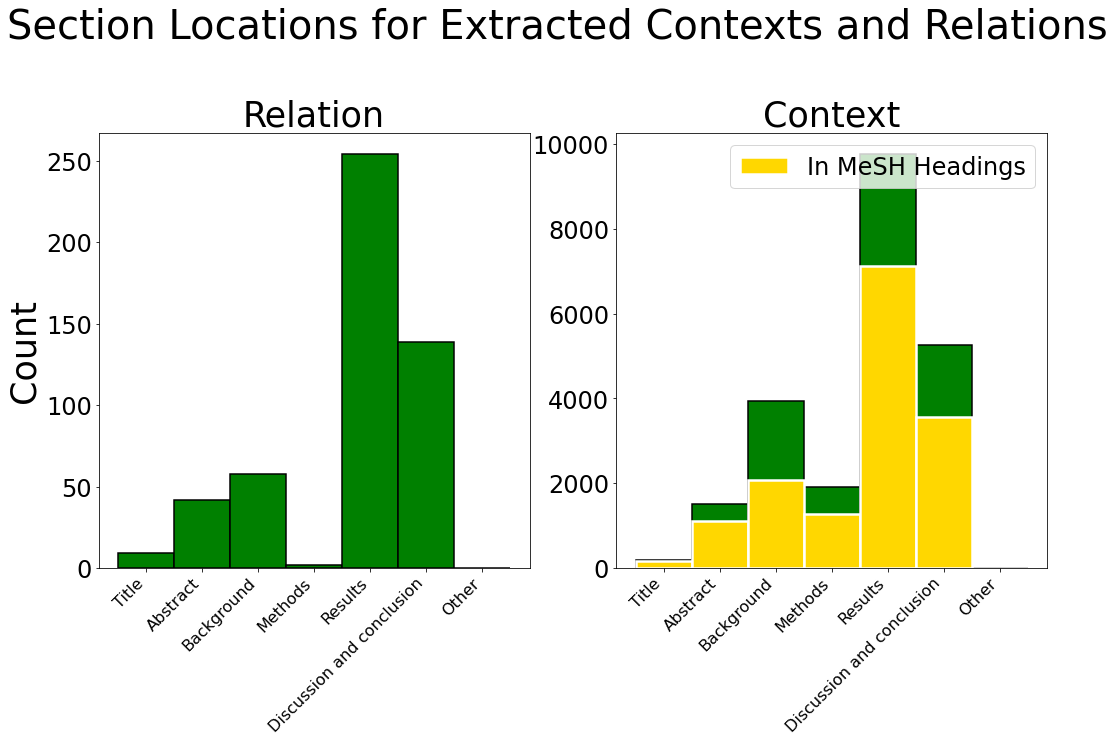

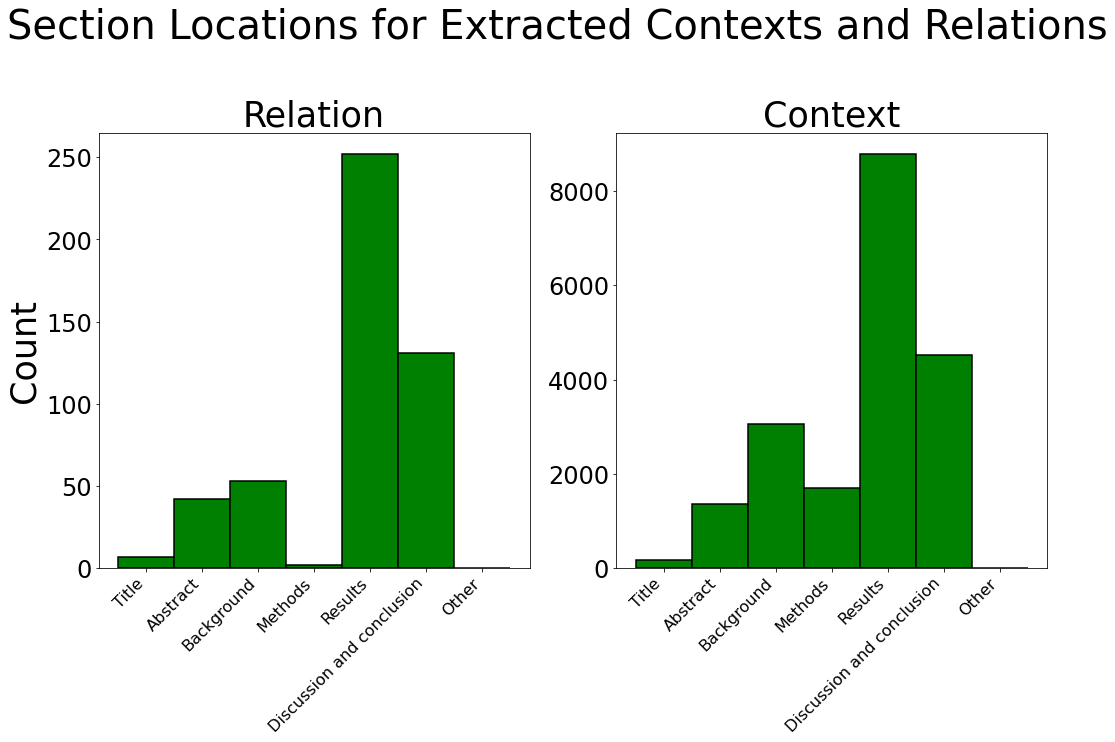

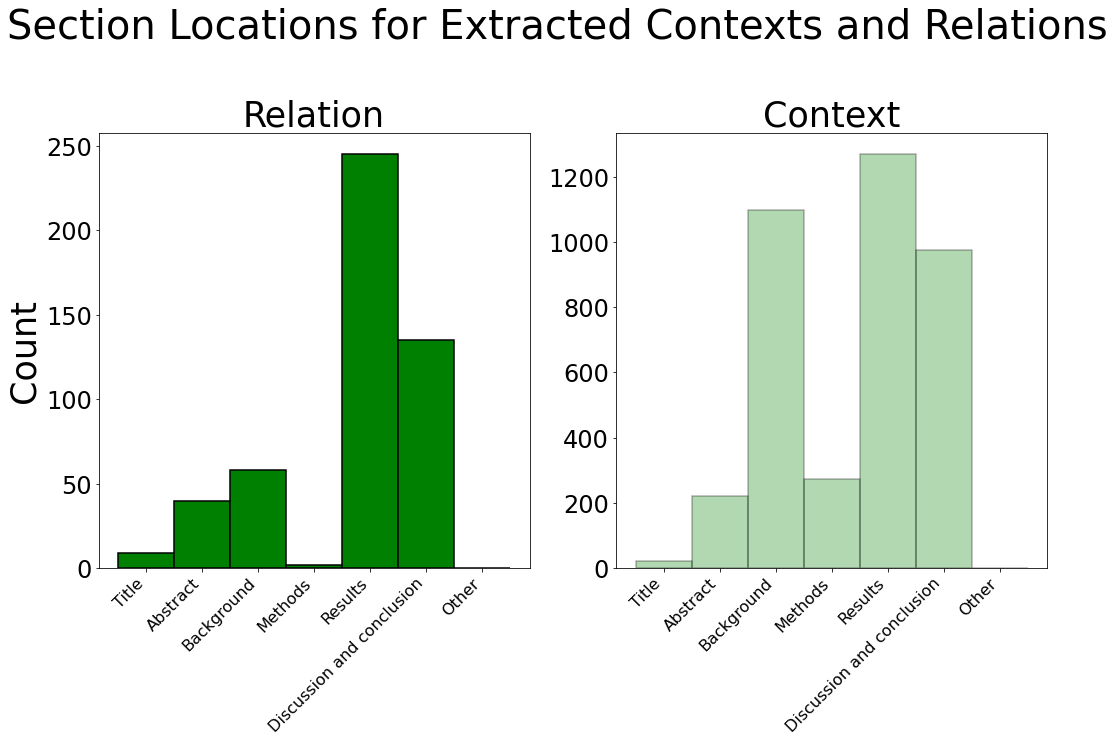

In [4]:
# Plot distributions. Note: plotting by individual mention in text, not by context generally (i.e. counts account for all mentions of 'hepatocyte' in a text)

draw_section_distribution(insider_df_CT_features_annots, in_mesh=True, out_dir=fig_out_dir, filename="InsiderCTAll")
draw_section_distribution(insider_df_CT_features_annots[insider_df_CT_features_annots.annotation], in_mesh=False, out_dir=fig_out_dir, filename="InsiderCTPos")
draw_section_distribution(insider_df_CT_features_annots[~insider_df_CT_features_annots.annotation], in_mesh=False, alpha=.3, out_dir=fig_out_dir, filename="InsiderCTNeg")

What is the relationship between "commonness" of the term and its appearance as a MeSH term. Namely, are really common terms (e.g. "macrophage") more likely to be annotated as a MeSH heading. Or maybe are really rare terms so significant as central topics that if they ever appear, they're a MeSH term in a paper? Let's explore what how correlated these variables are.

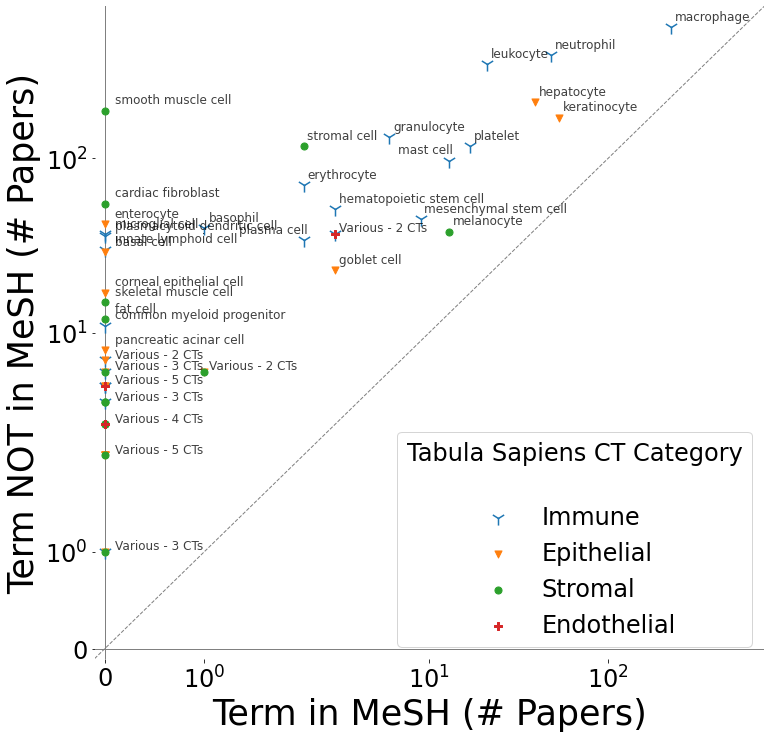

In [5]:
draw_CTs_in_mesh_counts(insider_df_CT_features, out_dir=fig_out_dir, filename="Insider")

Okay, now we're ready to train our classifiers--let's see some results!

N negatives: 1130
N positives: 491
Total len of resulting DF: 1621


N negatives - after up/down-weighting: 491
N positives - after up/down-weighting: 491
Total len of resulting DF: 982
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.9390243902439024
Looking at clf: SVC - Linear
Accuracy 0.9298780487804879
Looking at clf: Random Forest
Accuracy 0.9542682926829268
Looking at clf: Feedforward Neural Net
Accuracy 0.948170731707317
Looking at clf: Gradient Boosted Trees
Accuracy 0.948170731707317


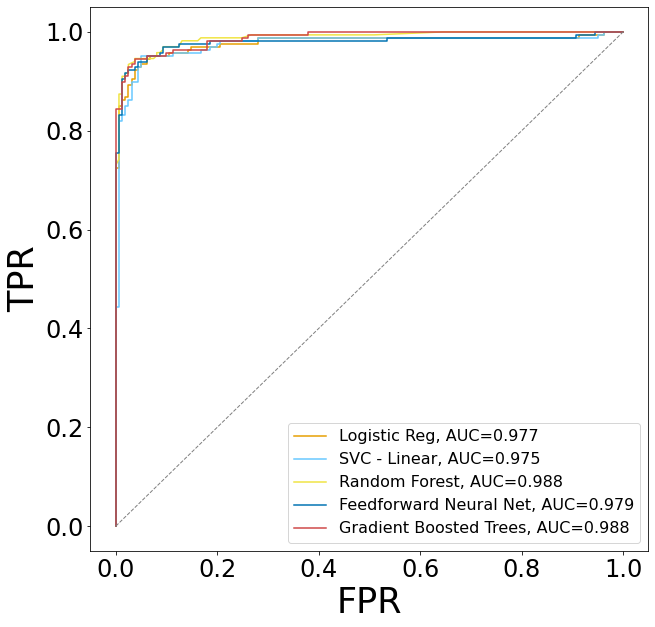

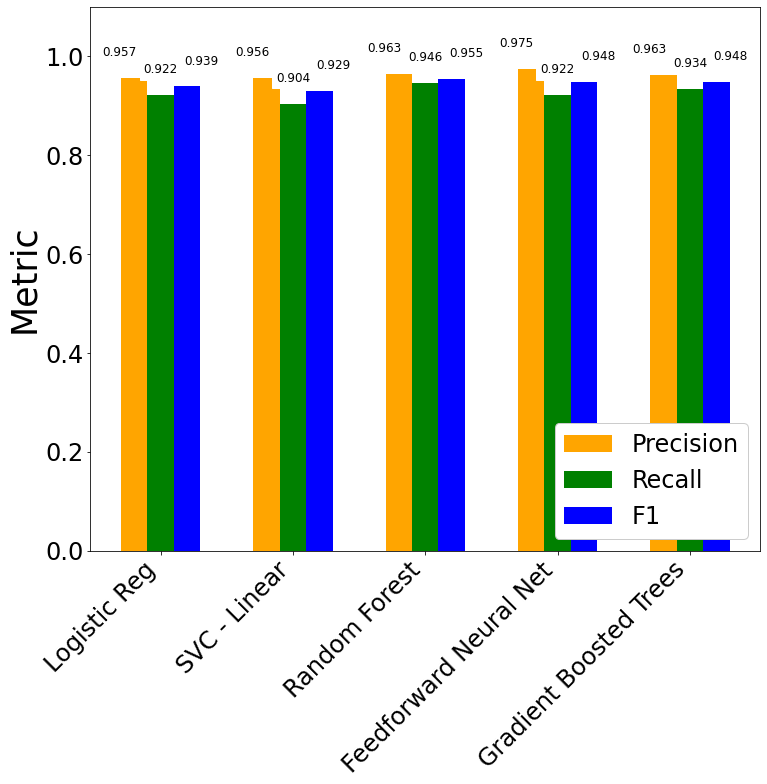

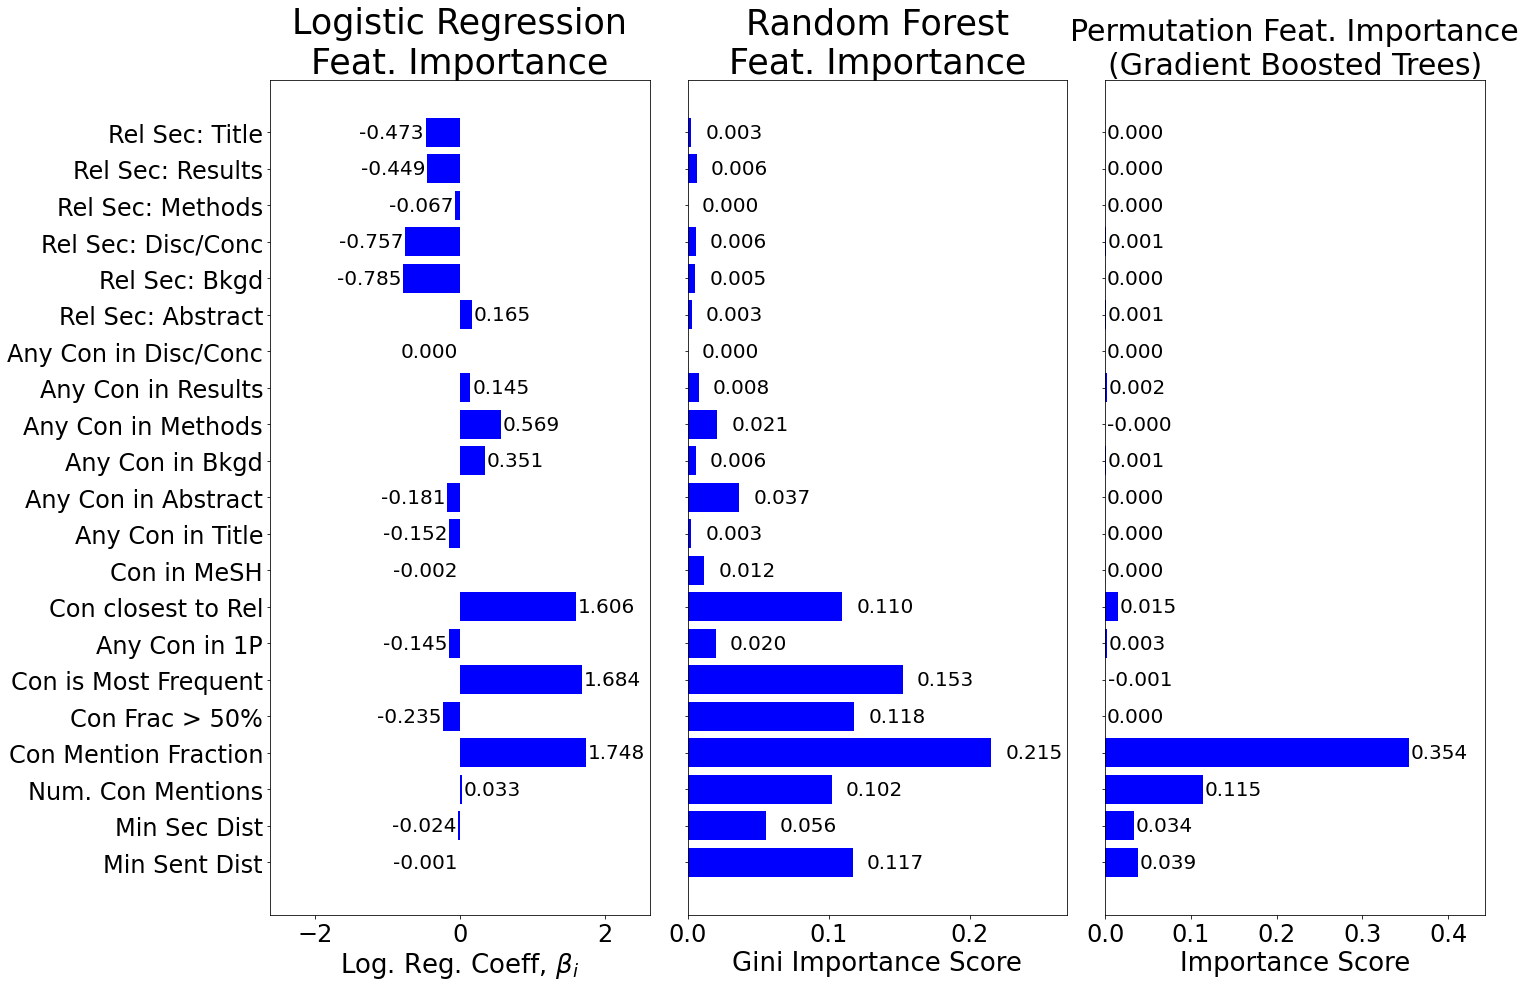

In [7]:
insider_CT_res_df, insider_CT_clf_list, insider_CT_predictions_df = generate_analysis_figs(insider_df_CT_features_annots, 
                                                                                           grouped_analysis=True,
                                                                                           downsample_maj=True,
                                                                                           upsample_min=False,
                                                                                           weight_imbalance=False,
                                                                                           plot_roc_curve=True,
                                                                                           plot_confusion_matrices=False,
                                                                                           plot_feature_analysis=True,
                                                                                           out_dir=fig_out_dir,
                                                                                           filename="insiderCT")


How far are our positive contexts away from the relation (excluding the context mention inside the insider of course)?

Number positive CTs with min sentence distance <= 5: 399 (81.3%)
Number positive CTs with min sentence distance >= 10: 60 (12.2%)


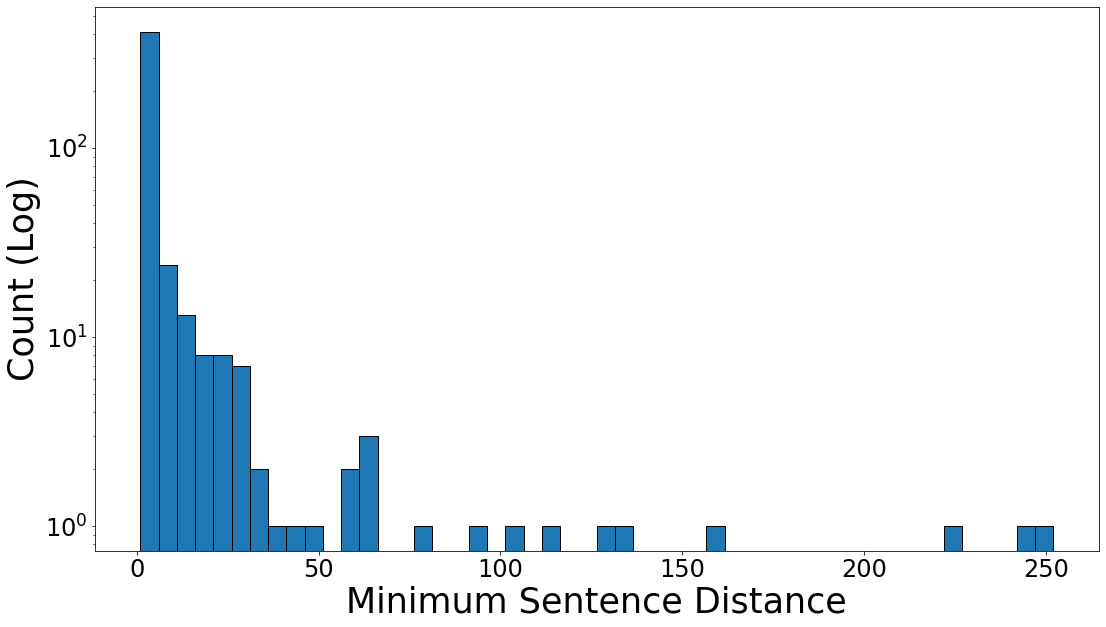

In [10]:
# Count the sentence distances within certain bounds
low_bound = 5
up_bound = 10
n_pos = len(insider_CT_res_df[insider_CT_res_df.annotation])
pos_within_lb = len(insider_CT_res_df[(insider_CT_res_df.annotation) & (insider_CT_res_df.min_sent_dist <= low_bound)])
pos_gt_ub = len(insider_CT_res_df[(insider_CT_res_df.annotation) & (insider_CT_res_df.min_sent_dist >= up_bound)])

print(f"Number positive CTs with min sentence distance <= {low_bound}: {pos_within_lb} ({round(pos_within_lb / n_pos, 3)*100}%)")
print(f"Number positive CTs with min sentence distance >= {up_bound}: {pos_gt_ub} ({round(pos_gt_ub / n_pos, 3)*100}%)")

# Plot the distribution of sentence distances
fig = plt.figure(figsize=(18, 10))

positives_sent_dists = np.array(insider_CT_res_df[insider_CT_res_df.annotation].min_sent_dist)
plt.hist(positives_sent_dists, edgecolor="black", bins=50)
plt.yscale('log')
plt.ylabel('Count (Log)')
plt.xlabel('Minimum Sentence Distance')

# Save file
out_file = os.path.join(fig_out_dir, f"MinSentDist_PositiveInsiderCT.png")
plt.savefig(out_file, dpi=300, bbox_inches="tight")
plt.show()

And we can check out some examples where the context is far away

In [11]:
insider_CT_res_df[insider_CT_res_df.annotation & (insider_CT_res_df.min_sent_dist >= 10)].head(3)

rel  \
569                                                                                                 Notably, we find that Wnt4 suppresses Tak1 activation induced by Rankl, resulting in the inhibition of IKK/NF-κB activation in macrophages and osteoclast precursors.   
769  Furthermore, DKK1 induces the expression of keratin 9 and α-Kelch-like ECT2 interacting protein (αKLEIP) but down-regulates the expression of β-catenin, glycogen synthase kinase 3β, protein kinase C and proteinase-activated receptor-2 (PAR-2) in keratinocytes.   
801                                                                                                                                                                         Using Western blotting, we confirmed an upregulation of MT1-MMP by C5a in leukocytes and MNC.   

              con  min_sent_dist  min_sec_dist  num_con_mentions  \
569    macrophage           29.0           6.0                20   
769  keratinocyte           19.0           6.0                18   
801     leukocyte           12.0           3.0                11   

     con_mention_frac  con_mention_50  is_con_mention_max  any_con_fp  \
569          0.952381            True                True        True   
769          0.580645            True                True        True   
801          0.323529           False               False        True   

     is_closest_cont_by_sent  con_in_mesh_headings               norm_rel_sec  \
569                     True                     0  discussion and conclusion   
769                    False                     1                   abstract   
801                    False                     0                    results   

     any_con_title  any_con_abstract  any_con_background  any_con_methods  \
569          False              True               False            False   
769          False             False                True            False   
801          False             False               False             True   

     any_con_results  any_con_disc_conc  annotation  
569             True              False        True  
769            False              False        True  
801             True              False        True

In [162]:
#### DELETE ME!!!


set(dl.all_pubmed_relations_df[dl.all_pubmed_relations_df.distance_to_nearest_sentence_with_citation > 0].head(100).rel)




{'Akt is a downstream mediator of PI3K and the growth factor receptor (GFR) stimulation of Akt has been shown to be dependent on PI3K activity.',
 'Although p62 alone increased the expression of GluR1 at the cell surface, inclusion of active aPKC resulted in a significant increase in GluR1 at the cell surface.',
 'Although we found that 15-HC can use the same pathway to activate PARP-1 in a cell-free system, our results have shown that TLR2 was required for the activation of PARP-1 by 15-HC in living cells in vitro and in vivo .',
 'As predicted, the MEK/ERK inhibitor U1026 and the pKa inhibitor H89 each attenuated the induction of PPARδ ( Fig. 2B ) and phospho-Rb (unpublished data) by EGF and TSH treatment, respectively.',
 'As shown in Figure 6B,D , ATF4 dose-dependently stimulated cyclin D1 expression both at the mRNA and protein level.',
 'Because Irgm1 itself is strongly induced by IFN-γ, we propose that it provides a positive feedback mechanism in the IFN-γ signaling pathway that

It's interesting to see what went wrong. Here are some false positives and false negatives.

In [12]:
# Error analysis

error_df_fns = insider_CT_predictions_df[(insider_CT_predictions_df.Label != insider_CT_predictions_df["Pred: Random Forest"]) & insider_CT_predictions_df.Label]
error_df_fps = insider_CT_predictions_df[(insider_CT_predictions_df.Label != insider_CT_predictions_df["Pred: Random Forest"]) & ~insider_CT_predictions_df.Label]

# The following were found from a head of both of the above dataframes
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC2884222']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC3849919']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC6103837']

#insider_df_CTs[insider_df_CTs.PMCID == 'PMC3561241']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC4644191']
#insider_df_CTs[insider_df_CTs.PMCID == 'PMC6864939']

It's also interesting to see how well our trained models do against simple benchmarks. Let's compare our best trained model to the benchmarks.

Looking at benchmark: any_rel_con_section_match
Accuracy 0.6629327902240326
Looking at benchmark: is_con_mention_max
Accuracy 0.9276985743380856
Looking at benchmark: con_mention_50
Accuracy 0.9154786150712831
Looking at benchmark: con_in_mesh_headings
Accuracy 0.7525458248472505
Looking at benchmark: min_sent_dist_1
Accuracy 0.7342158859470469
Looking at benchmark: min_sent_dist_2
Accuracy 0.8228105906313645
Looking at benchmark: min_sent_dist_3
Accuracy 0.8421588594704684
Looking at benchmark: min_sent_dist_4
Accuracy 0.8492871690427699
Looking at benchmark: min_sent_dist_5
Accuracy 0.8564154786150713
Looking at benchmark: min_sent_dist_6
Accuracy 0.8615071283095723


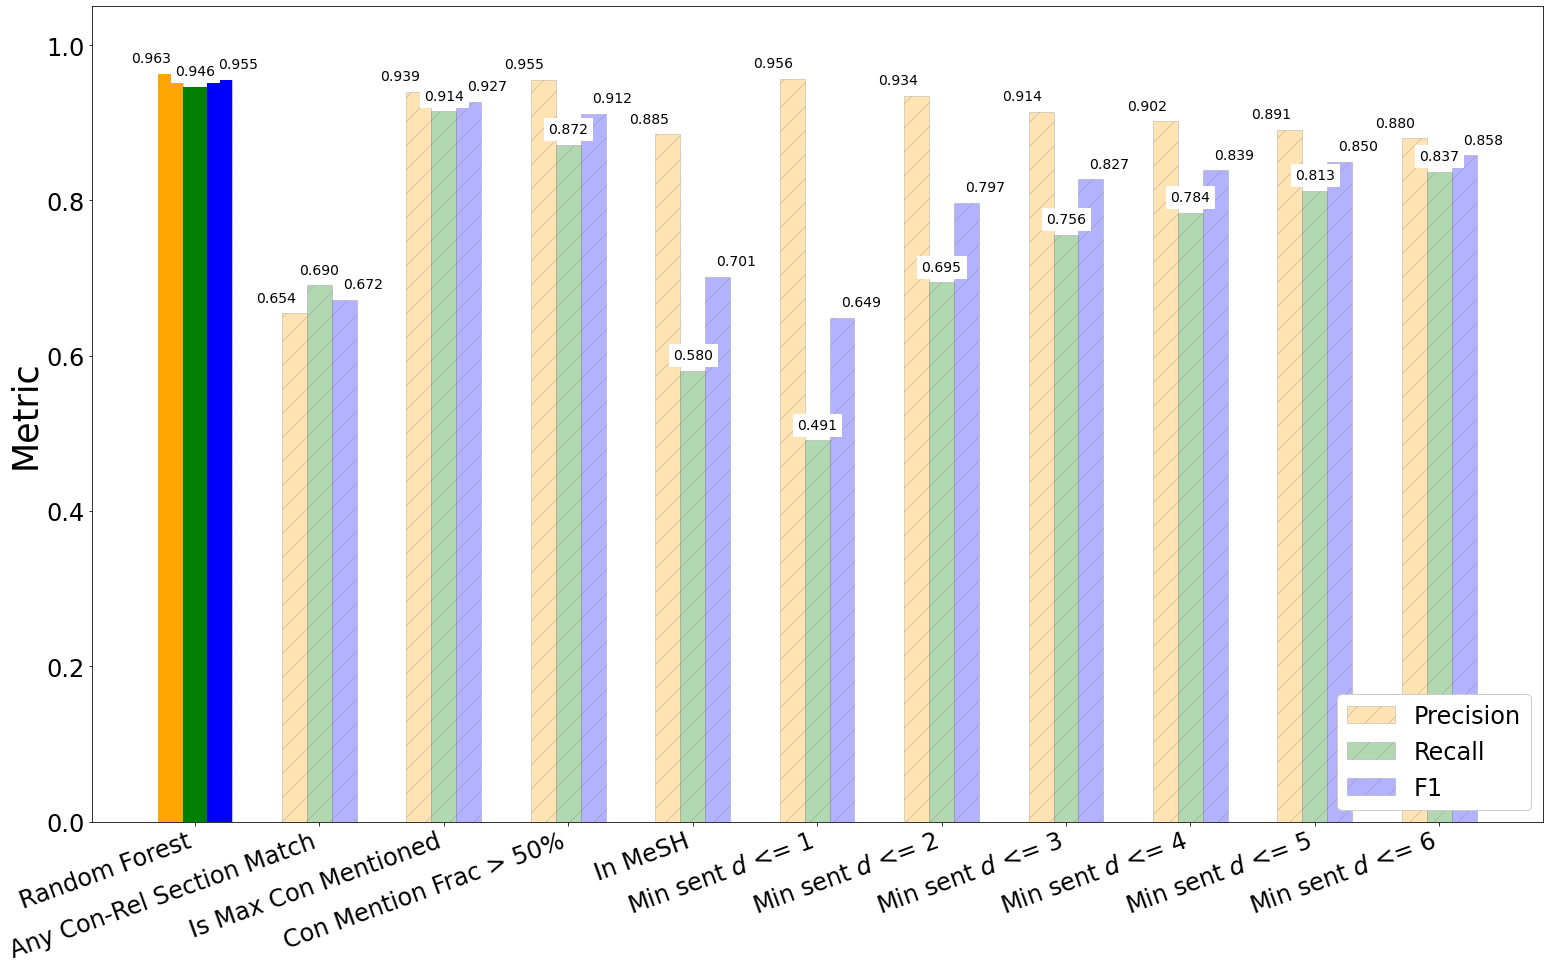

In [13]:
plot_benchmark_fig(insider_CT_res_df, 
                   best_model_name="Random Forest", 
                   best_model_stats=[0.963, 0.946, 0.955],
                   out_dir=fig_out_dir,
                   filename="insiderCT")

#### Transfer to Insider Tissue Analysis

Now, we'll take our pipeline for cell types and see how well it does on a different context--tissues

Number of unique papers with inside sentences --  parotid gland: 1
Number of unique papers with inside sentences --  endometrium: 3
Number of unique papers with inside sentences --  muscle tissue: 2
Number of unique papers with inside sentences --  thymus: 6
Number of unique papers with inside sentences --  tongue: 4
Number of unique papers with inside sentences --  submandibular gland: 2
Number of unique papers with inside sentences --  adipose tissue: 73
Number of unique papers with inside sentences --  cornea: 18
Number of unique papers with inside sentences --  trachea: 3
Number of unique papers with inside sentences --  coronary artery: 3
Number of unique papers with inside sentences --  spleen: 13
Number of unique papers with inside sentences --  conjunctiva: 3
Number of unique papers with inside sentences --  kidney: 44
Number of unique papers with inside sentences --  sclera: 1
Number of unique papers with inside sentences --  blood: 33
Number of unique papers with inside sente

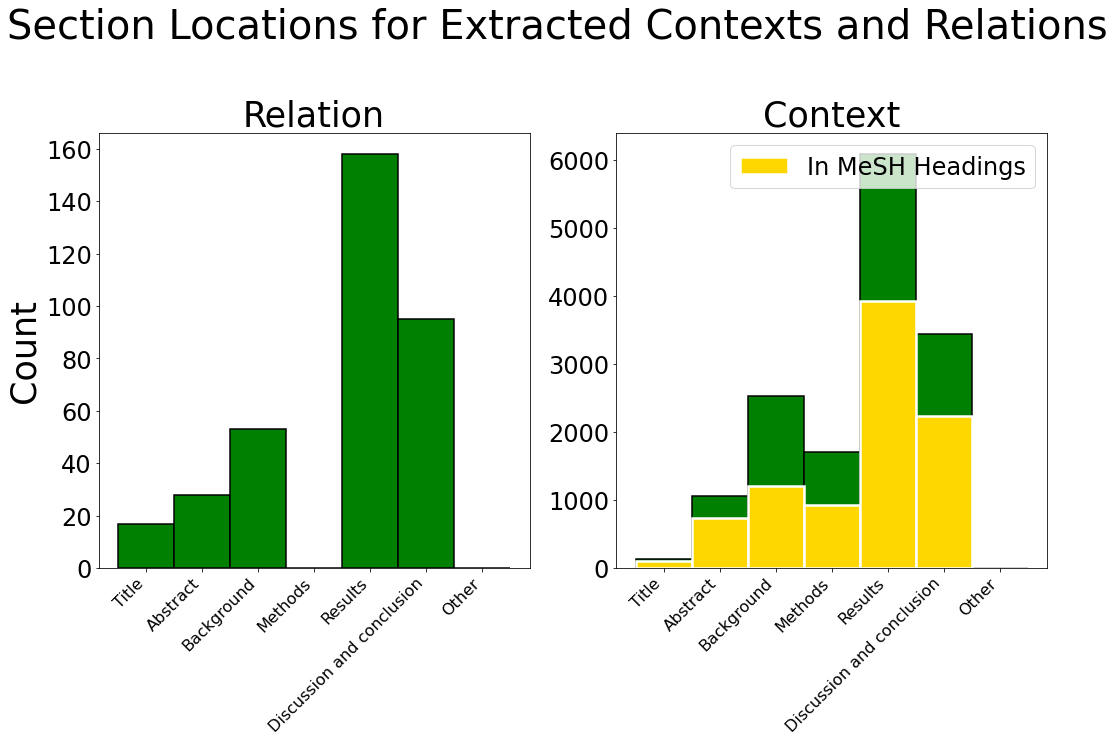

In [14]:
#insider_df_tissue_features_path = "/Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/new_NER_v2/tissues_insider_papers_features_df.tsv"

# Load the previously extracted features
insider_df_tissue_features_path = os.path.join(out_dir, "tissues_insider_papers_features_df.tsv")
insider_df_tissue_features = pd.read_csv(insider_df_tissue_features_path, sep='\t')

# Generate the Insider corpus
insider_df_tissues = dl.create_insider_corpus(context_type="tissues")

# Combine the two to label the featurized papers based on Insider sentences
insider_df_tissue_features_annots = include_annotations_in_insider_corpus(insider_df_tissues, insider_df_tissue_features)

# Visualize the section distributions
draw_section_distribution(insider_df_tissue_features_annots, 
                          out_dir=fig_out_dir, 
                          filename="insiderTissues")


Run the same classification pipeline as before, now for tissues

N negatives: 822
N positives: 344
Total len of resulting DF: 1166


N negatives - after up/down-weighting: 822
N positives - after up/down-weighting: 344
Total len of resulting DF: 1166
norm_rel_sec_methods not found in column list. Assigning it a column of falses
List of 5 pre-trained models provided. No need to initialize new models.
Looking at clf: Logistic Reg
Accuracy 0.8996569468267581
Looking at clf: SVC - Linear
Accuracy 0.9150943396226415
Looking at clf: Random Forest
Accuracy 0.9125214408233276
Looking at clf: Feedforward Neural Net
Accuracy 0.8996569468267581
Looking at clf: Gradient Boosted Trees
Accuracy 0.9099485420240138


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/

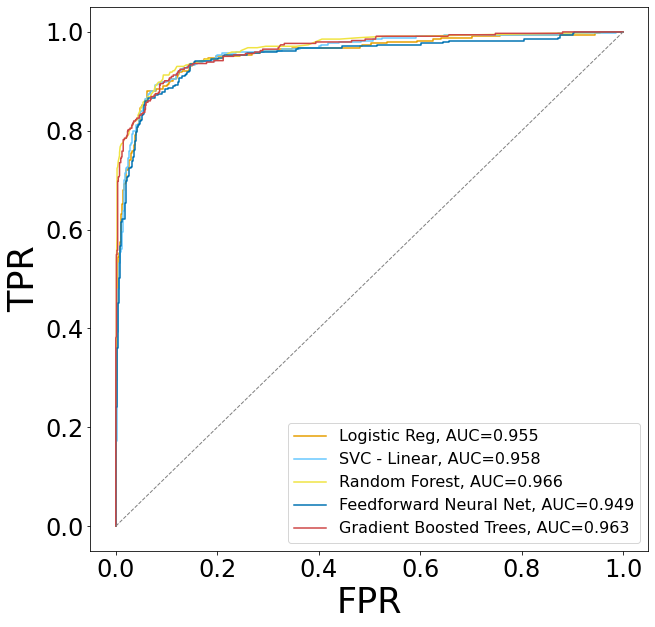

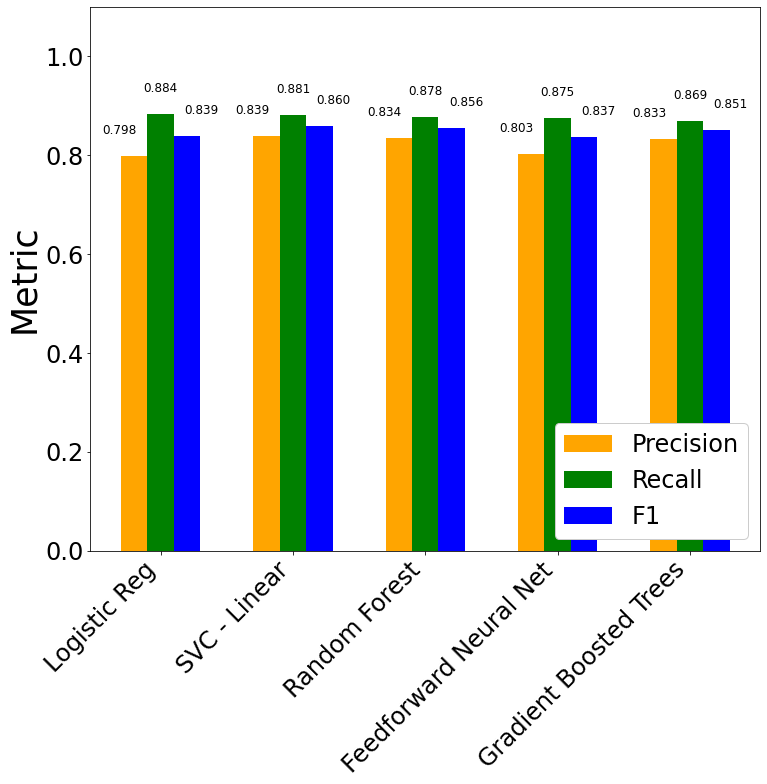

In [15]:
insider_tissue_res_df, _, insider_tissue_predictions_df = generate_analysis_figs(insider_df_tissue_features_annots, 
                                                  grouped_analysis=True,
                                                  downsample_maj=False,
                                                  upsample_min=False,
                                                  weight_imbalance=False,
                                                  in_clf_list=insider_CT_clf_list,
                                                  plot_roc_curve=True,
                                                  plot_confusion_matrices=False,
                                                  plot_feature_analysis=False,
                                                  out_dir=fig_out_dir,
                                                  filename="insiderTissues")



... and look at performance compared to benchmarks

Looking at benchmark: any_rel_con_section_match
Accuracy 0.6286449399656947
Looking at benchmark: is_con_mention_max
Accuracy 0.9150943396226415
Looking at benchmark: con_mention_50
Accuracy 0.9202401372212693
Looking at benchmark: con_in_mesh_headings
Accuracy 0.8147512864493996
Looking at benchmark: min_sent_dist_1
Accuracy 0.7898799313893653
Looking at benchmark: min_sent_dist_2
Accuracy 0.8198970840480274
Looking at benchmark: min_sent_dist_3
Accuracy 0.8319039451114922
Looking at benchmark: min_sent_dist_4
Accuracy 0.8276157804459692
Looking at benchmark: min_sent_dist_5
Accuracy 0.8190394511149228
Looking at benchmark: min_sent_dist_6
Accuracy 0.8087478559176673


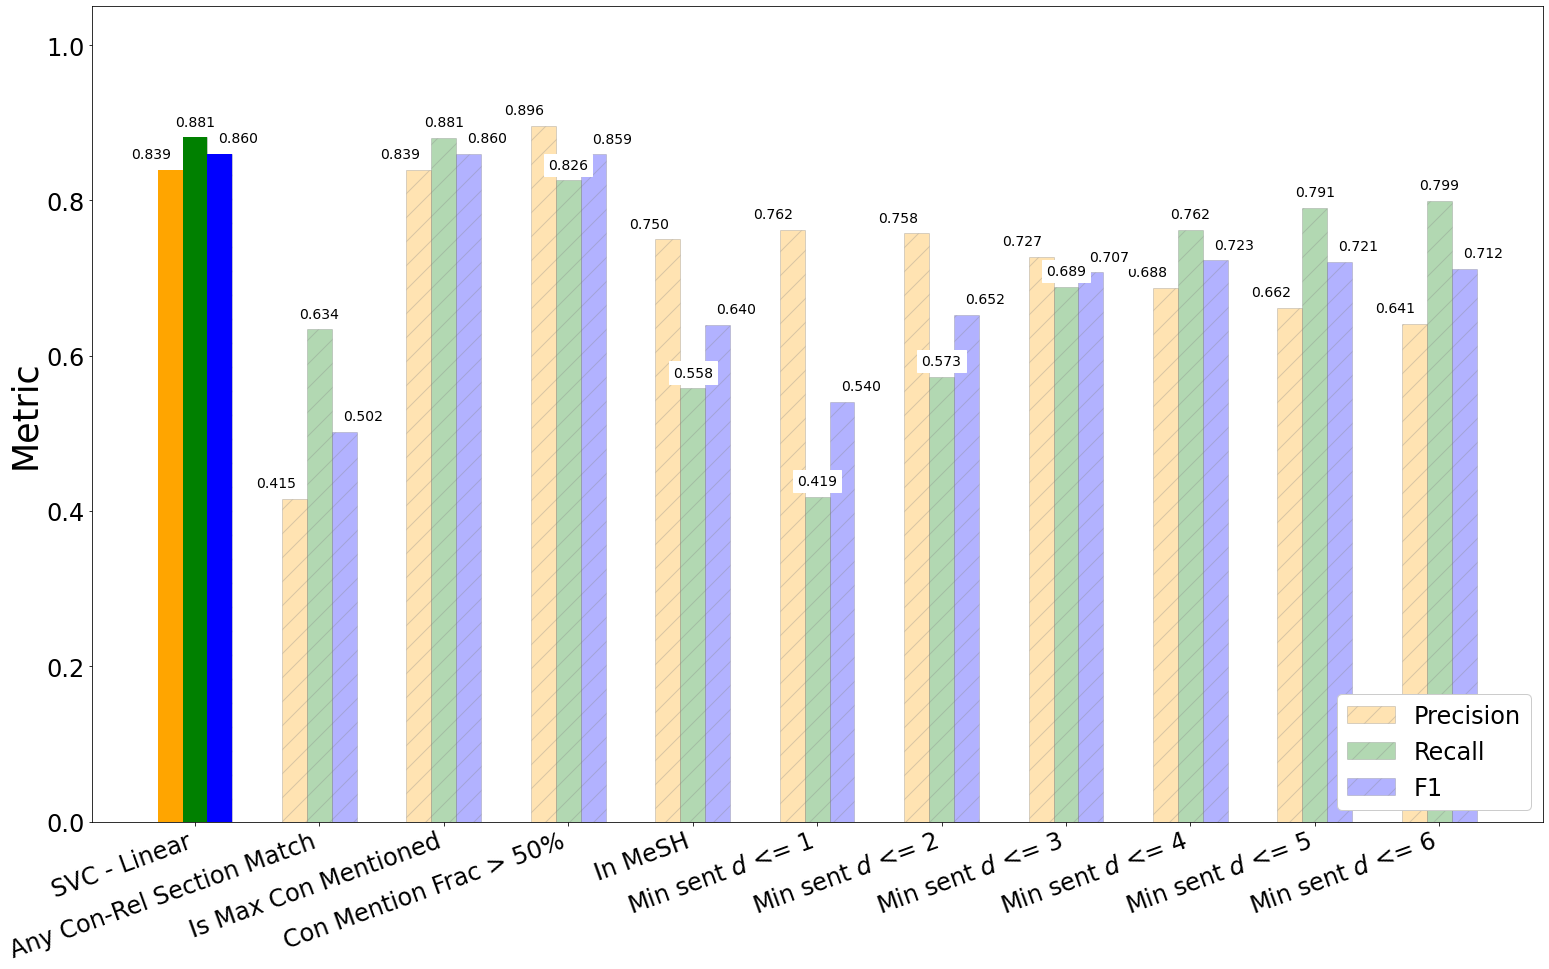

In [17]:
# Check that all the columns are fleshed out since the classifiers will expect the full number of columns

plot_benchmark_fig(insider_tissue_res_df, 
                   best_model_name="SVC - Linear",
                   best_model_stats=[0.839, 0.881, 0.860],
                   out_dir=fig_out_dir,
                   filename="insiderTissues")

#### Now demonstrating improvement over combining the two groups

In this section we look at how performance changes when I mix the two lexicons together as opposed to separating them into single context types.

N negatives: 1130
N positives: 491
Total len of resulting DF: 1621


N negatives - after up/down-weighting: 1130
N positives - after up/down-weighting: 491
Total len of resulting DF: 1621
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.933456561922366
Looking at clf: SVC - Linear
Accuracy 0.9316081330868762
Looking at clf: Random Forest
Accuracy 0.9371534195933456
Looking at clf: Feedforward Neural Net
Accuracy 0.922365988909427
Looking at clf: Gradient Boosted Trees
Accuracy 0.9297597042513863


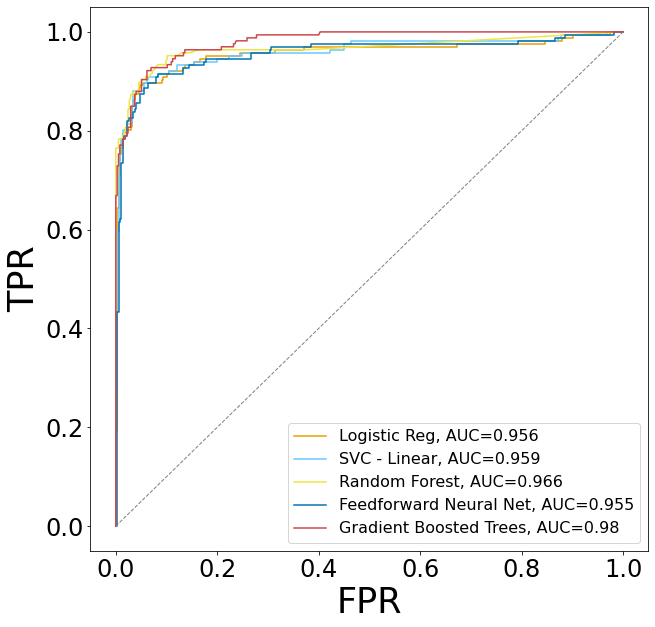

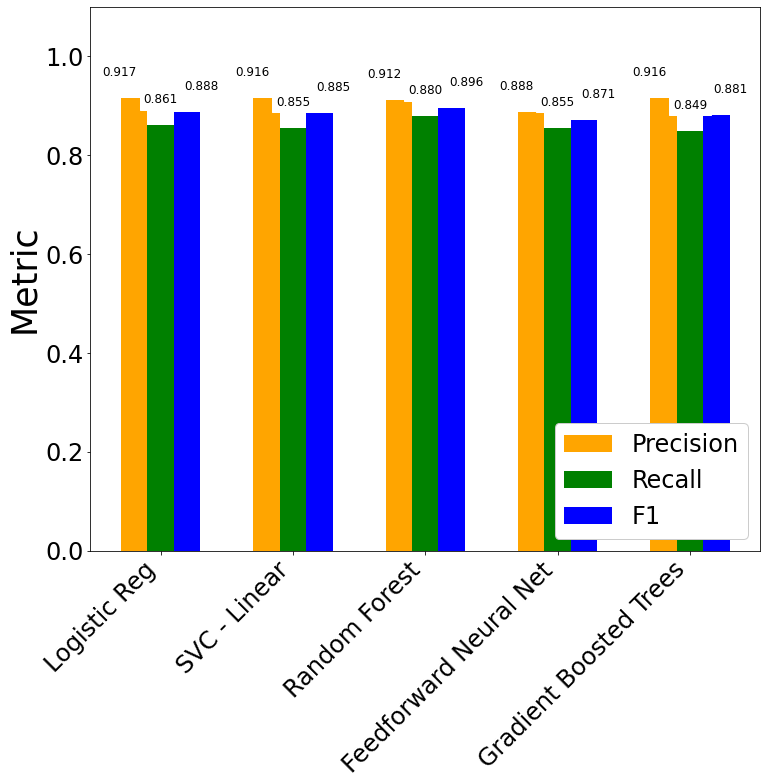

In [18]:
# First, let's recalculate the CT analyses with no downsampling

insider_CT_res_noDown_df, _, _ = generate_analysis_figs(insider_df_CT_features_annots, 
                                                        grouped_analysis=True,
                                                        downsample_maj=False,
                                                        upsample_min=False,
                                                        weight_imbalance=False,
                                                        plot_roc_curve=True,
                                                        plot_confusion_matrices=False,
                                                        plot_feature_analysis=False,
                                                        out_dir=fig_out_dir,
                                                        filename="insiderCT_noDownsample")

N negatives: 3944
N positives: 835
Total len of resulting DF: 4779


N negatives - after up/down-weighting: 3944
N positives - after up/down-weighting: 835
Total len of resulting DF: 4779
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net
Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.9290646578782172
Looking at clf: SVC - Linear
Accuracy 0.9278091650973007
Looking at clf: Random Forest
Accuracy 0.9365976145637163
Looking at clf: Feedforward Neural Net
Accuracy 0.933458882611425
Looking at clf: Gradient Boosted Trees
Accuracy 0.9441305712492153


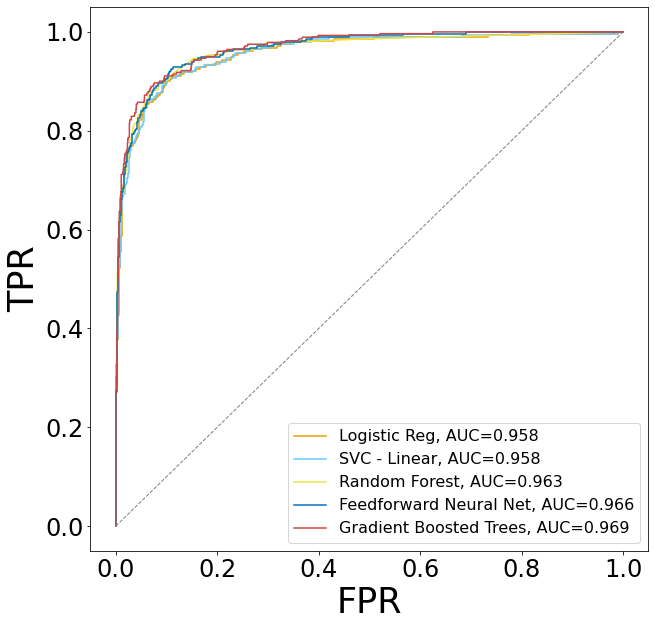

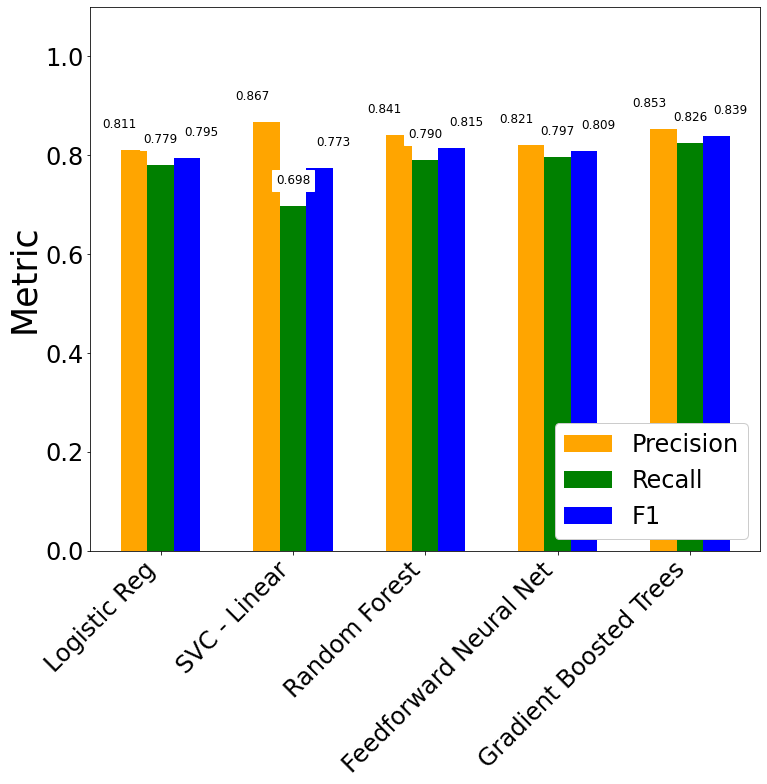

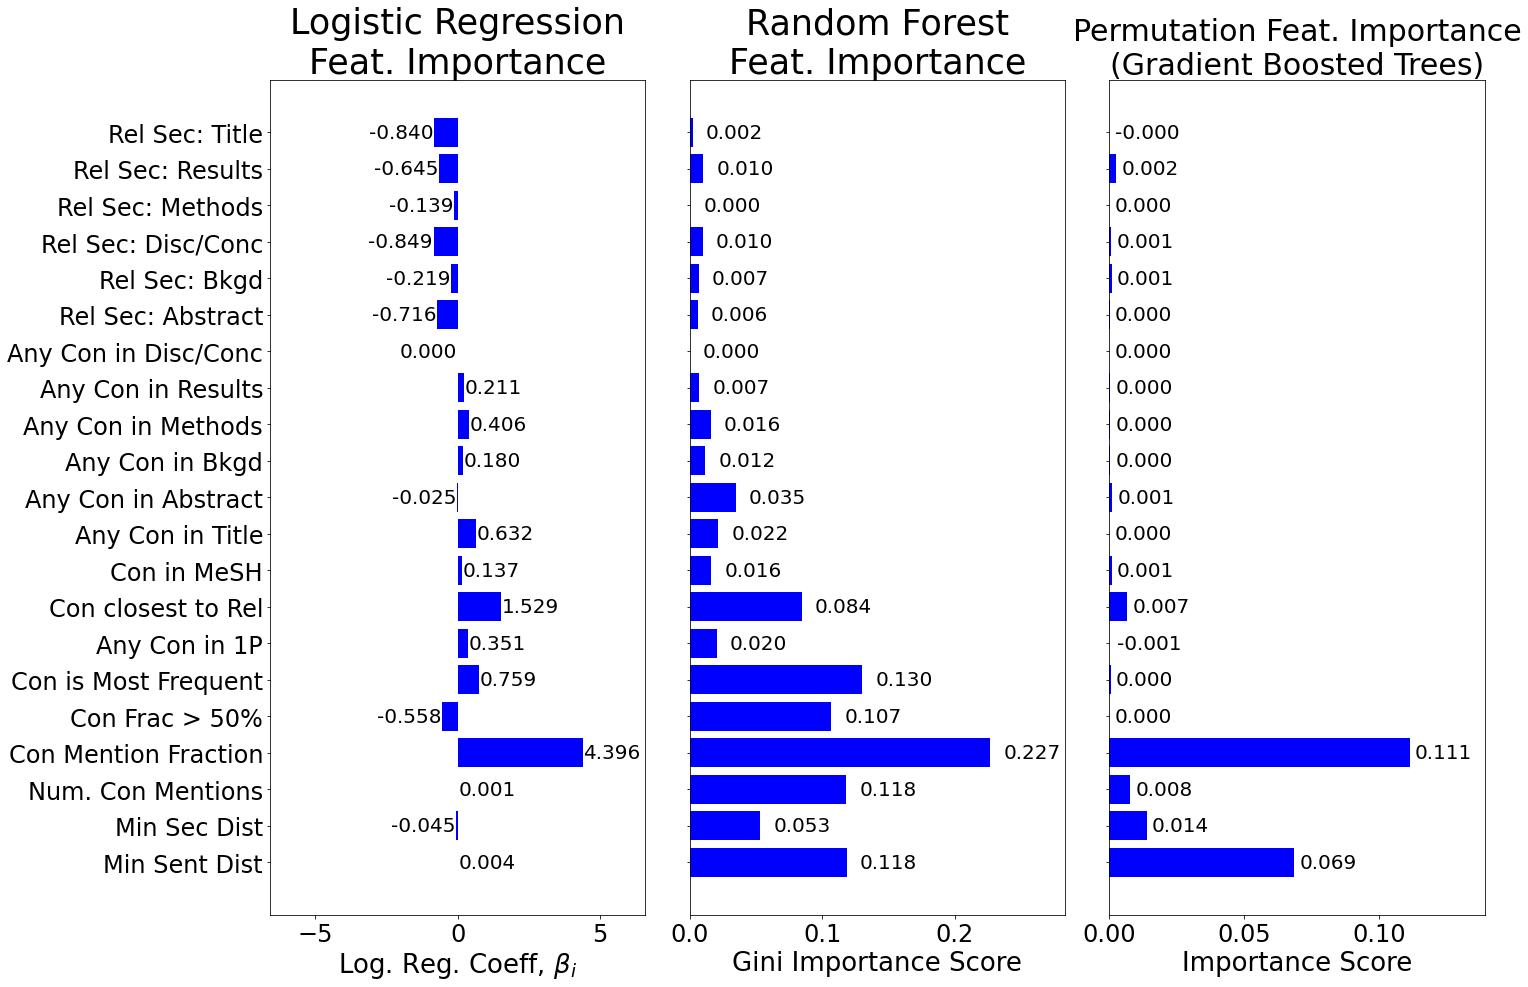

In [19]:
# Let's now calculate the classification results with CT + Tissue types mixed together

insider_df_combined_features_path = os.path.join(out_dir, "combined_insider_papers_features_df.tsv")
insider_df_combined_features = pd.read_csv(insider_df_combined_features_path, sep='\t')

insider_df_combined_positives = pd.concat([insider_df_CTs, insider_df_tissues])

insider_df_combined_features_annots = include_annotations_in_insider_corpus(insider_df_combined_positives, insider_df_combined_features)


insider_combined_res_df, insider_combined_clf_list, insider_combined_predictions_df = generate_analysis_figs(insider_df_combined_features_annots, 
                                                                                           grouped_analysis=True,
                                                                                           downsample_maj=False,
                                                                                           upsample_min=False,
                                                                                           weight_imbalance=False,
                                                                                           plot_roc_curve=True,
                                                                                           plot_confusion_matrices=False,
                                                                                           plot_feature_analysis=True,
                                                                                           out_dir=fig_out_dir,
                                                                                           filename="insiderCombined")

Threshold for 90% recall: 0.447
Precision for 90% recall: 0.898
Threshold for 90% recall: 0.333
Precision for 90% recall: 0.801


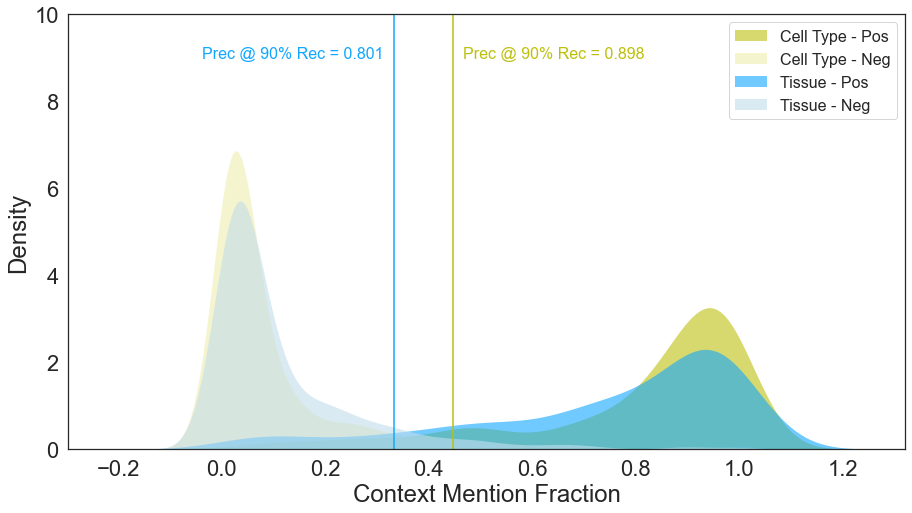

Threshold for 90% recall: 0.193
Precision for 90% recall: 0.619


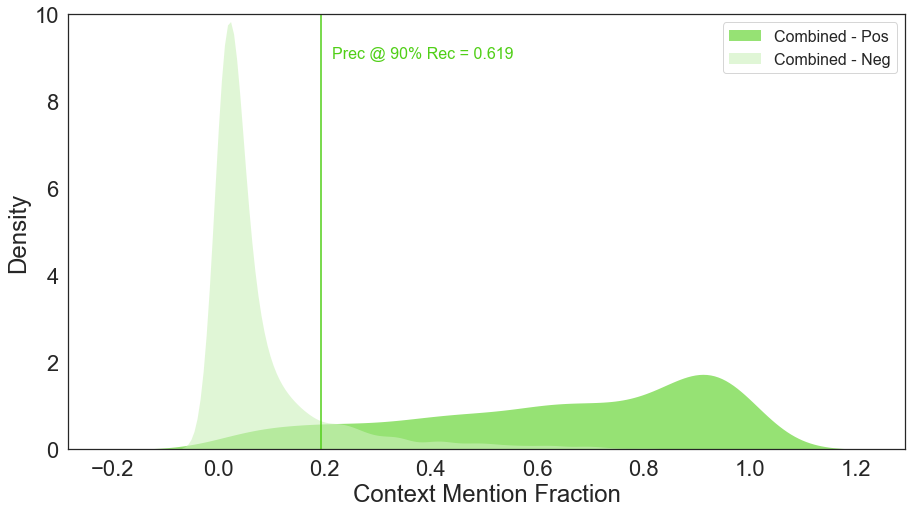

In [22]:
# Finally, let's check out how precision changes using the important context mention fraction feature on the single context type lexicon versus the combined.

plot_con_mention_frac_precision_plots(insider_CT_res_noDown_df, 
                                      insider_tissue_res_df, 
                                      insider_combined_res_df, 
                                      fig_out_dir)


#### ENA Validation

In [72]:
# Pre-processing ENA data

from lit_contextizer.data_models.PaperUtilities import extract_features
from lit_contextizer.data_models.Utilities import load_all_groundings

ena_df_path = "/Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/extracted_features_enrique_papers_v3.csv"

all_annotators_df, annotated_connects = dl.parse_annotation_files_for_ena()
ena_df = extract_features(dl.ena_paper_pile, 
                          annotated_connects=annotated_connects, 
                          do_calculate_pmi=False, 
                          do_calculate_in_mesh=True, 
                          biocxmls_pubmed_dir="/Users/dnsosa/Desktop/AltmanLab/bai/biotext/pubmed_texts",
                          is_enrique=True)
ena_df.to_csv(ena_df_path)


/Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/src/lit_contextizer/data_models/DataLoader.py:385: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Index(['paper_id', 'rel', 'con', 'con_sent', 'con_type', 'ent_1', 'ent_2',
       'sent_dist', 'sec_dist', 'rel_sec', 'norm_rel_sec', 'con_sec',
       'norm_con_sec', 'num_con_mentions', 'is_con_fp', 'con_in_mesh_headings',
       'annotation', 'con_mention_frac', 'con_mention_50',
       'num_con_mentions_max', 'is_con_mention_max'],
      dtype='object')


N negatives: 2688
N positives: 314
Total len of resulting DF: 3002


N negatives - after up/down-weighting: 2688
N positives - after up/down-weighting: 314
Total len of resulting DF: 3002
norm_rel_sec_title not found in column list. Assigning it a column of falses
norm_rel_sec_methods not found in column list. Assigning it a column of falses
List of 5 pre-trained models provided. No need to initialize new models.
Looking at clf: Logistic Reg
Accuracy 0.8937375083277814
Looking at clf: SVC - Linear
Accuracy 0.8650899400399733
Looking at clf: Random Forest
Accuracy 0.893404397068621
Looking at clf: Feedforward Neural Net
Accuracy 0.8777481678880746
Looking at clf: Gradient Boosted Trees
Accuracy 0.880413057961359


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/

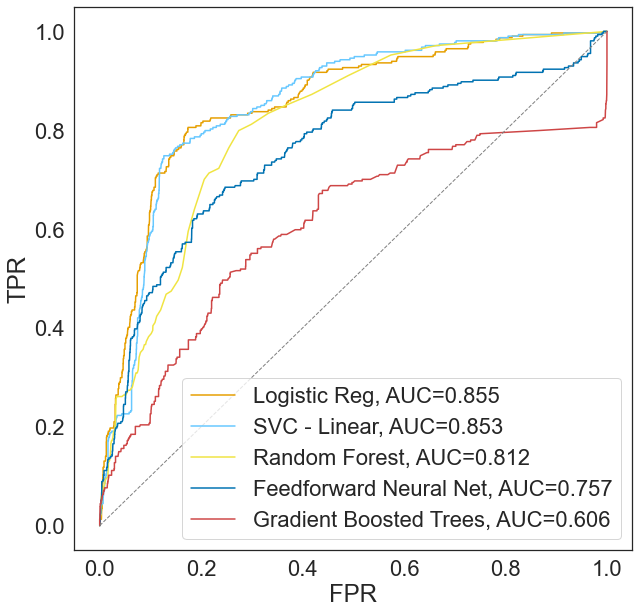

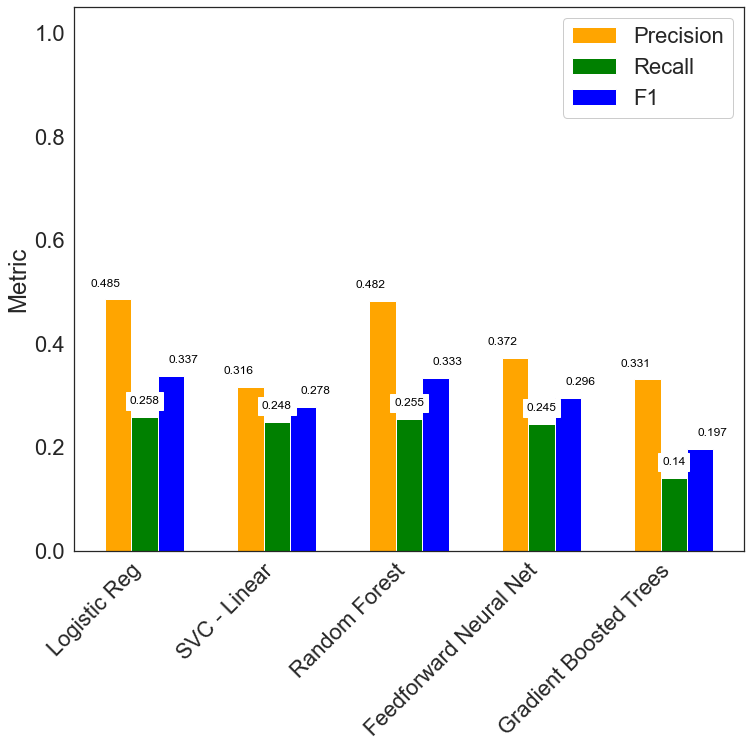

In [73]:
# ENA DF
# Transferred model

ena_df_res, _, _ = generate_analysis_figs(ena_df, 
                       grouped_analysis=True,
                       downsample_maj=False,
                       upsample_min=False,
                       weight_imbalance=False,
                       in_clf_list=insider_CT_clf_list,
                       plot_roc_curve=True,
                       plot_confusion_matrices=False,
                       plot_feature_analysis=False,
                       in_loc="upper right",
                       out_dir=fig_out_dir,
                       filename="ENAInsiderCTTransferred")

Looking at benchmark: any_rel_con_section_match
Accuracy 0.49766822118587606
Looking at benchmark: is_con_mention_max
Accuracy 0.8650899400399733
Looking at benchmark: con_mention_50
Accuracy 0.8904063957361759
Looking at benchmark: con_in_mesh_headings
Accuracy 0.832778147901399
Looking at benchmark: min_sent_dist_1
Accuracy 0.9037308461025982
Looking at benchmark: min_sent_dist_2
Accuracy 0.8890739506995337
Looking at benchmark: min_sent_dist_3
Accuracy 0.8634243837441705
Looking at benchmark: min_sent_dist_4
Accuracy 0.8494337108594271
Looking at benchmark: min_sent_dist_5
Accuracy 0.835109926715523
Looking at benchmark: min_sent_dist_6
Accuracy 0.8151232511658895


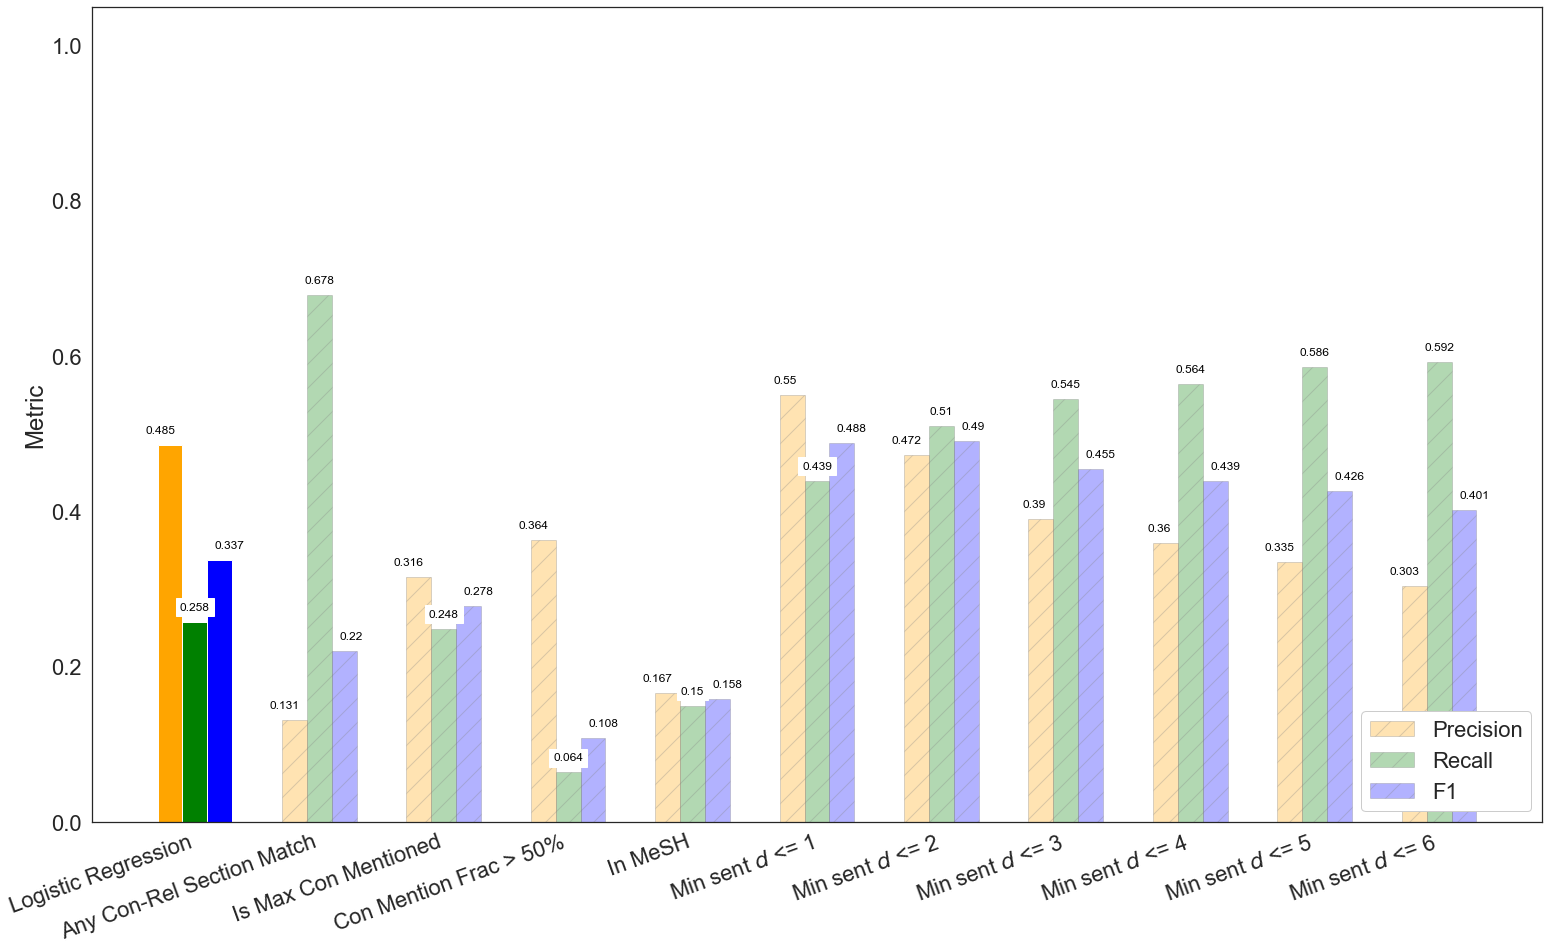

In [193]:
plot_benchmark_fig(ena_df_res, 
                   best_model_name="Logistic Regression", 
                   best_model_stats=[.485, .258, .337],
                   out_dir=fig_out_dir,
                   filename="ENAInsiderCTTransferred"
                   )

N negatives: 2688
N positives: 314
Total len of resulting DF: 3002


N negatives - after up/down-weighting: 314
N positives - after up/down-weighting: 314
Total len of resulting DF: 628
norm_rel_sec_title not found in column list. Assigning it a column of falses
norm_rel_sec_methods not found in column list. Assigning it a column of falses
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.7714285714285715
Looking at clf: SVC - Linear
Accuracy 0.7857142857142857
Looking at clf: Random Forest
Accuracy 0.8380952380952381
Looking at clf: Feedforward Neural Net
Accuracy 0.8238095238095238
Looking at clf: Gradient Boosted Trees
Accuracy 0.8333333333333334


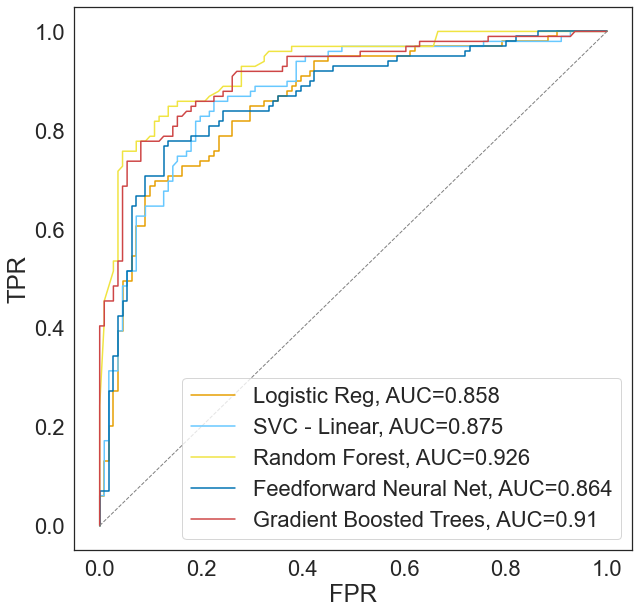

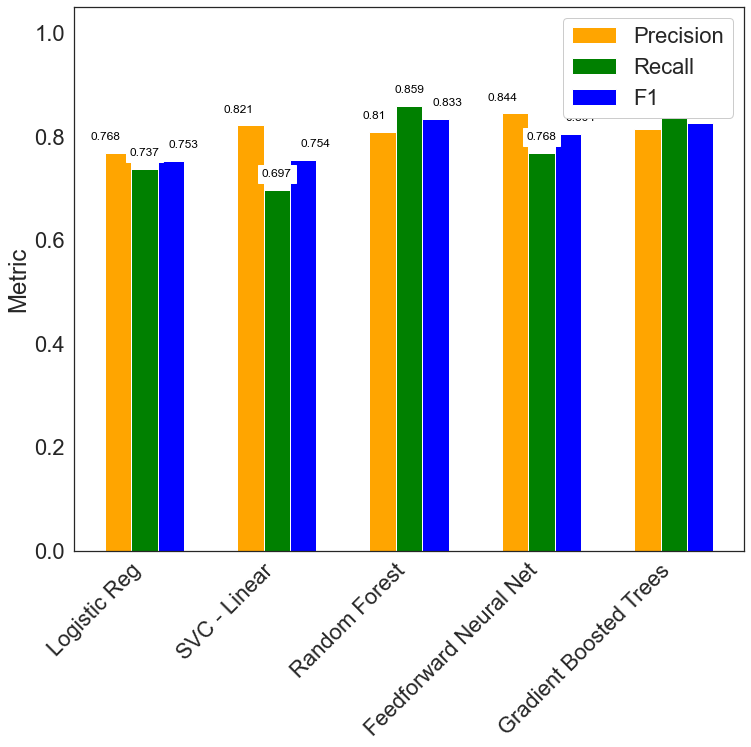

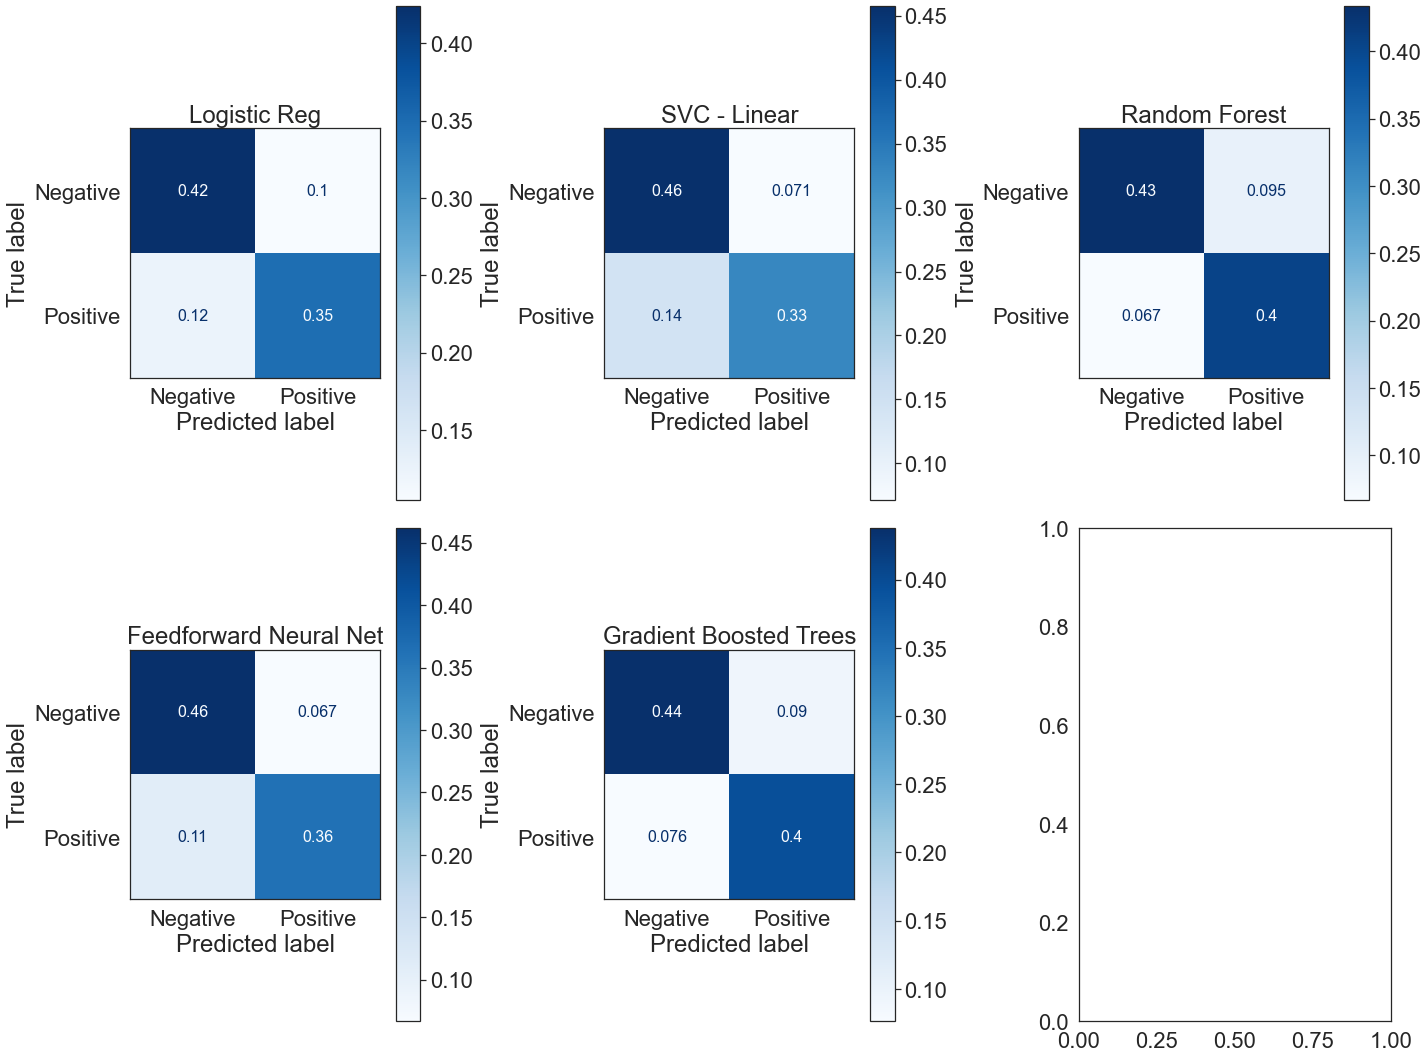

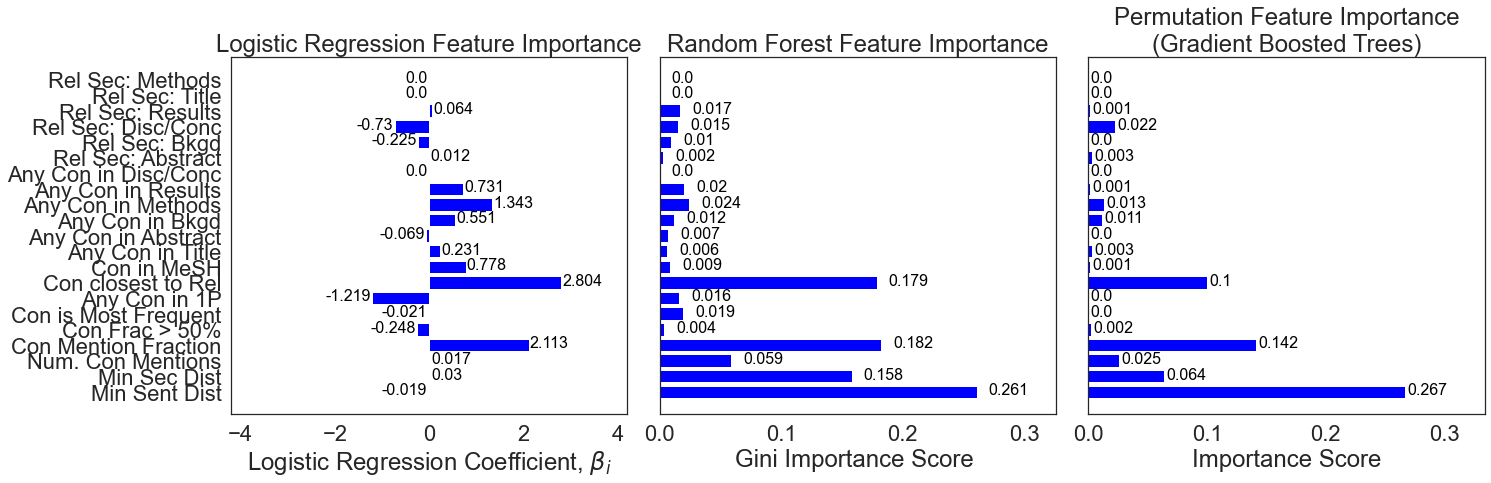

In [74]:
# ENA DF

# Retrained model
ena_df_res, _, _ = generate_analysis_figs(ena_df, 
                       grouped_analysis=True,
                       downsample_maj=True,
                       upsample_min=False,
                       weight_imbalance=True,
                       #in_clf_list=insider_CT_clf_list,
                       plot_roc_curve=True,
                       plot_confusion_matrices=True,
                       plot_feature_analysis=True,
                       in_loc="upper right",
                       out_dir=fig_out_dir,
                       filename="ENAInsiderCTRetrained")

Looking at benchmark: any_rel_con_section_match
Accuracy 0.5843949044585988
Looking at benchmark: is_con_mention_max
Accuracy 0.589171974522293
Looking at benchmark: con_mention_50
Accuracy 0.5302547770700637
Looking at benchmark: con_in_mesh_headings
Accuracy 0.5222929936305732
Looking at benchmark: min_sent_dist_1
Accuracy 0.697452229299363
Looking at benchmark: min_sent_dist_2
Accuracy 0.7197452229299363
Looking at benchmark: min_sent_dist_3
Accuracy 0.7197452229299363
Looking at benchmark: min_sent_dist_4
Accuracy 0.7245222929936306
Looking at benchmark: min_sent_dist_5
Accuracy 0.7197452229299363
Looking at benchmark: min_sent_dist_6
Accuracy 0.7117834394904459


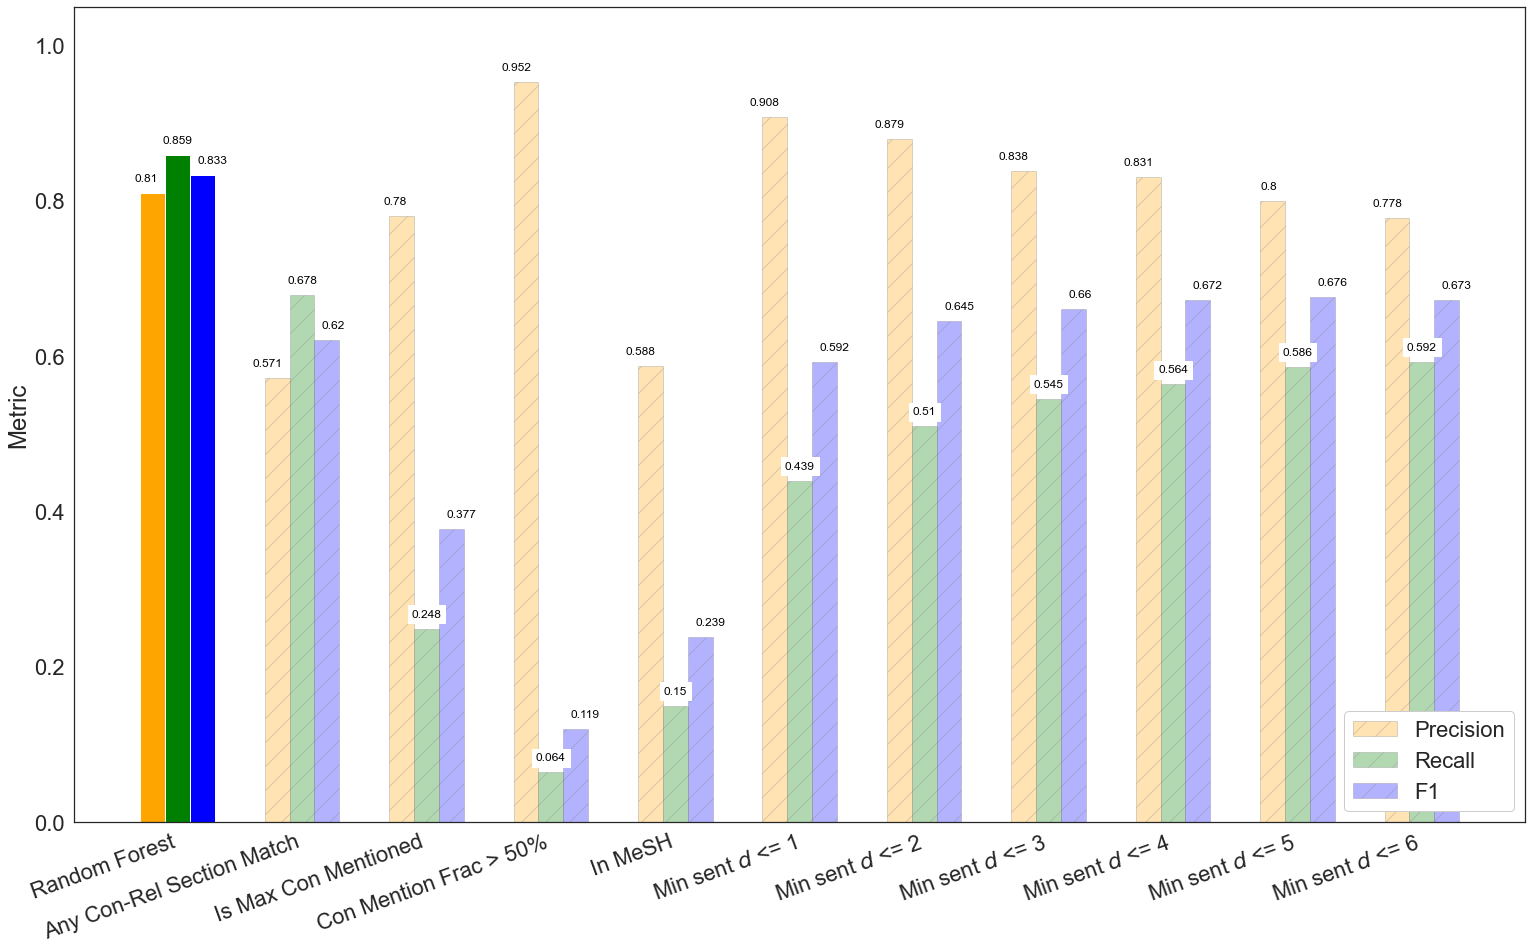

In [195]:
# Check that all the columns are fleshed out since the classifiers will expect the full number of columns

plot_benchmark_fig(ena_df_res, 
                   best_model_name="Random Forest", 
                   best_model_stats=[.810, .859, .833],
                   out_dir=fig_out_dir,
                   filename="ENAInsiderCTRetrained")

### GIANT DS PPI

In [9]:
import os
import pandas as pd

out_dir = "/Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/new_NER_v2"

adipose_res_path = os.path.join(out_dir, "adipose_tissue_ppi_pmc_df.csv")
#cardiac_res_path = os.path.join(out_dir, "cardiac_muscle_ppi_pmc_df.csv")
liver_res_path = os.path.join(out_dir, "liver_ppi_pmc_df.csv")
lung_res_path = os.path.join(out_dir, "lung_ppi_pmc_df.csv")
#pancreatic_res_path = os.path.join(out_dir, "pancreatic_islet_ppi_pmc_df.csv")

adipose_res = pd.read_csv(adipose_res_path)
#cardiac_res = pd.read_csv(cardiac_res_path)
liver_res = pd.read_csv(liver_res_path)
lung_res = pd.read_csv(lung_res_path)
#pancreatic_res = pd.read_csv(pancreatic_res_path)


adipose_res["context_term"] = "adipose tissue"
adipose_res["context_term_prefix"] = "adipo"

#cardiac_res["context_term"] = "cardiac"
#cardiac_res["context_term_prefix"] = "cardiac"

liver_res["context_term"] = "liver"
liver_res["context_term_prefix"] = "liver"

lung_res["context_term"] = "lung"
lung_res["context_term_prefix"] = "lung"

#pancreatic_res["context_term"] = "pancreatic"
#pancreatic_res["context_term_prefix"] = "islet"  # NOTE: not islets specifically 

#all_res_combined = pd.concat([adipose_res, cardiac_res, liver_res, lung_res, pancreatic_res], ignore_index=True)
all_res_combined = pd.concat([adipose_res, liver_res, lung_res], ignore_index=True)


In [10]:
print("Adipose:")
print(len(adipose_res))
adipose_res50 = adipose_res[adipose_res.Conf >= 0.5]
print(len(adipose_res50))
adipose_res90 = adipose_res[adipose_res.Conf >= 0.9]
print(len(adipose_res90))

print("\nLiver:")
print(len(liver_res))
liver_res50 = liver_res[liver_res.Conf >= 0.5]
print(len(liver_res50))
liver_res90 = liver_res[liver_res.Conf >= 0.9]
print(len(liver_res90))

print("\nLung:")
print(len(lung_res))
lung_res50 = lung_res[lung_res.Conf >= 0.5]
print(len(lung_res50))
lung_res90 = lung_res[lung_res.Conf >= 0.9]
print(len(lung_res90))

giant_positives_df = all_res_combined[['rel', 'context_term']]
giant_positives_df.columns = ["Extracted Relation", "Context"]

all_res_combined50 = pd.concat([adipose_res50, liver_res50, lung_res50], ignore_index=True)
all_res_combined90 = pd.concat([adipose_res90, liver_res90, lung_res90], ignore_index=True)

ppi_ds_features_df = pd.read_csv(os.path.join(out_dir,  "ppi_pmc_tissues_features_df.csv"))

ppi_ds_features_df50 = ppi_ds_features_df.merge(all_res_combined50, on='rel', how='inner')
ppi_ds_features_df90 = ppi_ds_features_df.merge(all_res_combined90, on='rel', how='inner')


Adipose:
1729
258
38

Liver:
3536
225
22

Lung:
5211
397
81


In [15]:
giant_triples = all_res_combined50[['rel', 'pmid', 'context_term']].drop_duplicates()
n_giant_triples_nonciting = len(giant_triples[giant_triples['rel'].isin(non_citing_relations)])
print(len(all_res_combined50))

NameError: name 'non_citing_relations' is not defined

rel  \
0                                                 Specifically, leptin inhibits MMP-1 expression in both rat HSCs and the human HSC line, LX-2, via Jak/Stat signaling [ Cao et al., 2007 ; Lin et al., 2006 ] .   
1  Recent experiments have also linked the cyclin/CDK4 complex to Akt in β-cell proliferation showing that Akt1 upregulates cyclin D1, cyclin D2 and p21Cip1 levels (but not p27Kip1) and CDK4 activity ( 143 ).   
2                                                                              These results demonstrate that suppression of PGC-1α target gene expression by twist-1 does not rely on its DNA binding activity.   
3                                                                                                                                                                                  TSC1 is a suppressor of mTOR.   
4            To sort out whether leptin up-regulates apoE gene expression directly or whether the altered apoE mRNA levels are secondary to changes of body weight, a pair-fed group of ob/ob mice was included.   

       pmid       pmcid  entity1  entity2 entity1_text entity2_text  \
0  20564215  PMC2907429  T180712  T180717       leptin        MMP-1   
1  18828795  PMC2630373   T68624   T68599         Akt1    cyclin D1   
2  19345188  PMC2688451  T288118  T288124       PGC-1α      twist-1   
3  31552471  PMC7671717  T205526  T205525         TSC1         mTOR   
4  19481557  PMC2757054  T455488  T455501       leptin         apoE   

                filename  distance_to_nearest_sentence_with_citation  \
0  pmc_00000002.bioc.xml                                         0.0   
1  pmc_00000004.bioc.xml                                         0.0   
2  pmc_00000021.bioc.xml                                         3.0   
3  pmc_00000349.bioc.xml                                         1.0   
4  pmc_00000022.bioc.xml                                         NaN   

   entity1_entrez  entity2_entrez combined_entities_key  Gene1  Gene2  \
0             890            7157              7157_890   7157    890   
1           64135             684             64135_684  64135    684   
2             468           10413             10413_468  10413    468   
3           10413             468             10413_468  10413    468   
4            4609            1520             1520_4609   1520   4609   

       Conf query_genes    context_term context_term_prefix  
0  0.731974    7157_890  adipose tissue               adipo  
1  0.822299   64135_684  adipose tissue               adipo  
2  0.552062   10413_468  adipose tissue               adipo  
3  0.552062   10413_468  adipose tissue               adipo  
4  0.557896   1520_4609  adipose tissue               adipo

In [76]:
# giant_df_features_annots = include_annotations_in_insider_corpus(giant_positives_df, ppi_ds_features_df)
# 
# giant_res_df, _, _ = generate_analysis_figs(giant_df_features_annots, 
#                                             grouped_analysis=True,
#                                             downsample_maj=False,
#                                             upsample_min=False,
#                                             weight_imbalance=False,
#                                             in_clf_list=insider_CT_clf_list,
#                                             plot_roc_curve=True,
#                                             plot_confusion_matrices=True,
#                                             plot_feature_analysis=False,
#                                             recall_only=True,
#                                             out_dir=fig_out_dir,
#                                             filename="giantTransfer")
# 
# plot_benchmark_fig(giant_res_df, 
#                    best_model_name="SVC - Linear", 
#                    best_model_stats=[.554],
#                    recall_only=True,
#                    out_dir=fig_out_dir,
#                    filename="giantTransfer")
# 

NameError: name 'giant_df_features_annots' is not defined

In [16]:
# Now take out any citing sentences

non_citing_relations = dl.all_pubmed_relations_df[dl.all_pubmed_relations_df.distance_to_nearest_sentence_with_citation > 0].rel.drop_duplicates()
print(f"Number of unique non-citing relations: {len(non_citing_relations)}")

giant_positives_df50 = all_res_combined50[['rel', 'context_term']]
giant_positives_df50.columns = ["Extracted Relation", "Context"]
giant_df_features_annots50 = include_annotations_in_insider_corpus(giant_positives_df50, ppi_ds_features_df50)

print("\n50 filtration")
print(len(giant_df_features_annots50))
giant_df_features_annots50NC = giant_df_features_annots50.merge(non_citing_relations, on="rel", how="inner")
print("and also not citing:")
print(len(giant_df_features_annots50NC))


Number of unique non-citing relations: 38097

50 filtration
26577
and also not citing:
9233


In [24]:
n_giant_50nc = len(giant_df_features_annots50NC[['rel', 'con', 'paper_id']].drop_duplicates())
print(f"Size of the resulting GIANT corpus, .5 conf filter, non-citing: {n_giant_50nc}")
n_giant_50nc_pos = len(giant_df_features_annots50NC[giant_df_features_annots50NC.annotation][['rel', 'con', 'paper_id']].drop_duplicates())
print(f"positives only: {n_giant_50nc_pos}")


Size of the resulting GIANT corpus, .5 conf filter, non-citing: 629
positives only: 217


N negatives: 373
N positives: 199
Total len of resulting DF: 572


N negatives - after up/down-weighting: 373
N positives - after up/down-weighting: 199
Total len of resulting DF: 572
norm_rel_sec_title not found in column list. Assigning it a column of falses
norm_rel_sec_abstract not found in column list. Assigning it a column of falses
norm_rel_sec_methods not found in column list. Assigning it a column of falses
List of 5 pre-trained models provided. No need to initialize new models.
Looking at clf: Logistic Reg
Accuracy 0.6923076923076923
Looking at clf: SVC - Linear
Accuracy 0.6713286713286714
Looking at clf: Random Forest
Accuracy 0.6625874125874126
Looking at clf: Feedforward Neural Net
Accuracy 0.6835664335664335
Looking at clf: Gradient Boosted Trees
Accuracy 0.6643356643356644


/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/

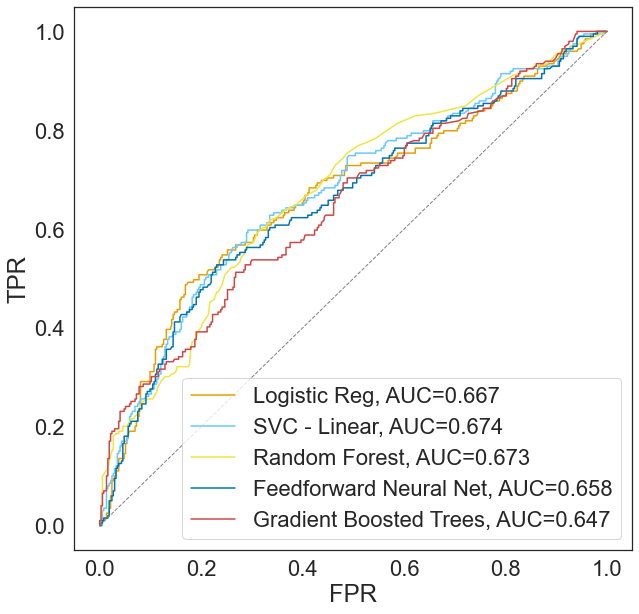

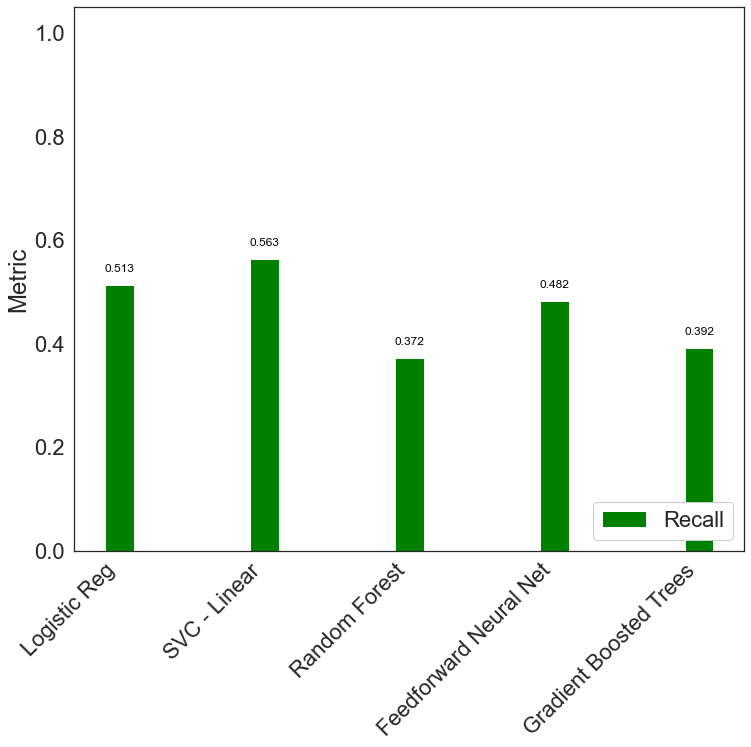

/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/dnsosa/opt/miniconda3/envs/

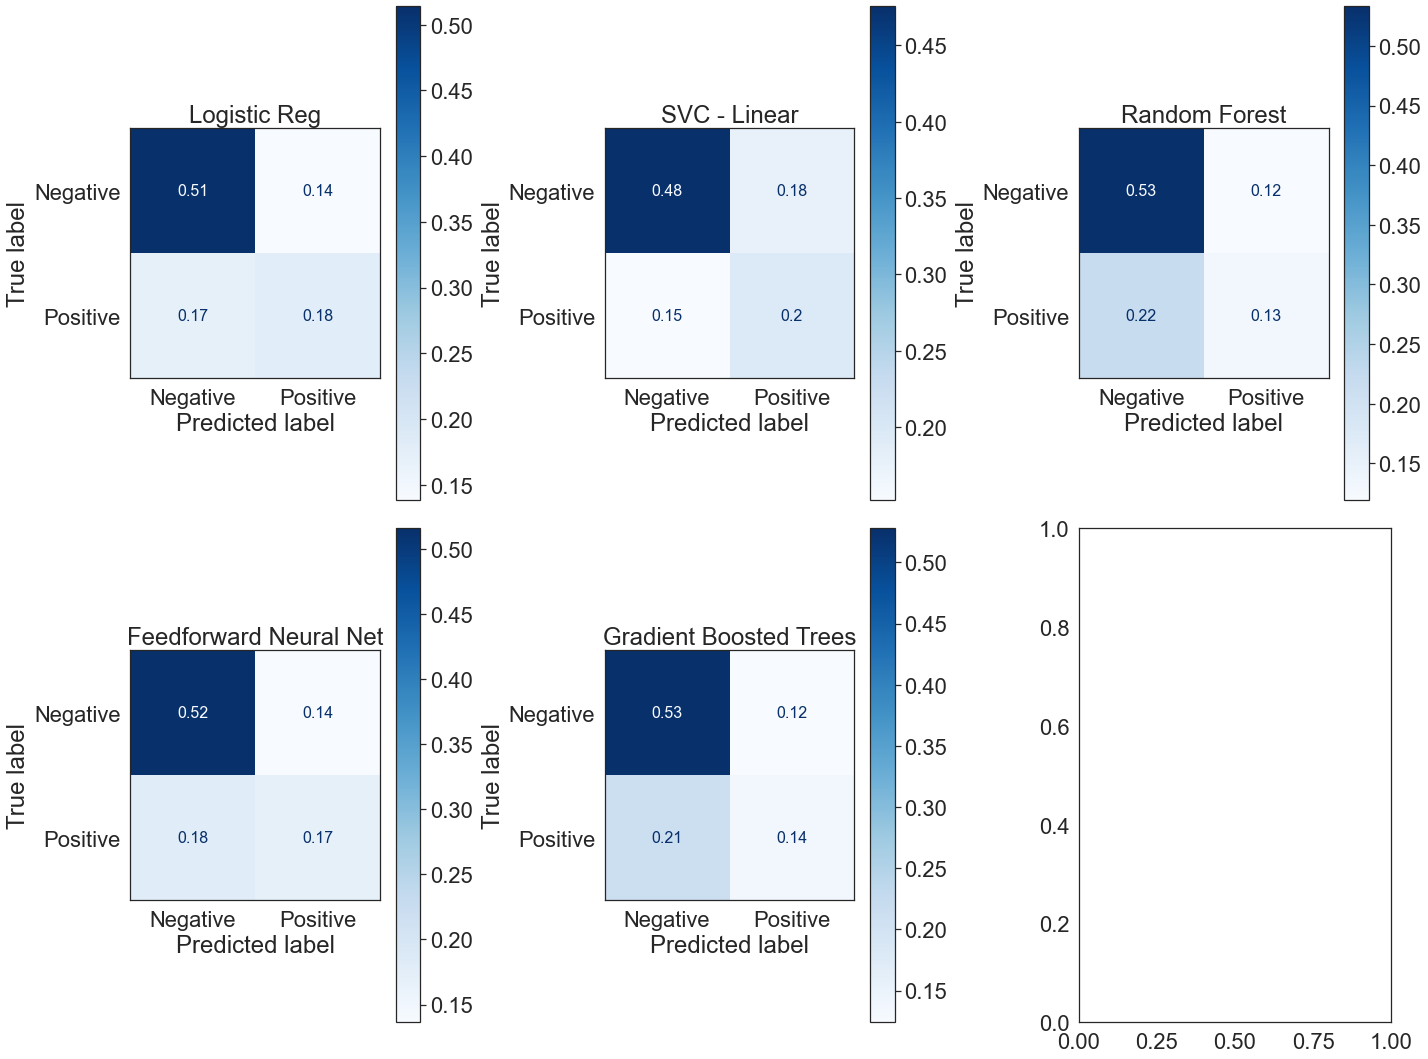

Looking at benchmark: any_rel_con_section_match
Accuracy 0.48426573426573427
Looking at benchmark: is_con_mention_max
Accuracy 0.6713286713286714
Looking at benchmark: con_mention_50
Accuracy 0.701048951048951
Looking at benchmark: con_in_mesh_headings
Accuracy 0.6555944055944056
Looking at benchmark: min_sent_dist_1
Accuracy 0.6520979020979021
Looking at benchmark: min_sent_dist_2
Accuracy 0.6520979020979021
Looking at benchmark: min_sent_dist_3
Accuracy 0.6520979020979021
Looking at benchmark: min_sent_dist_4
Accuracy 0.6573426573426573
Looking at benchmark: min_sent_dist_5
Accuracy 0.6416083916083916
Looking at benchmark: min_sent_dist_6
Accuracy 0.6381118881118881


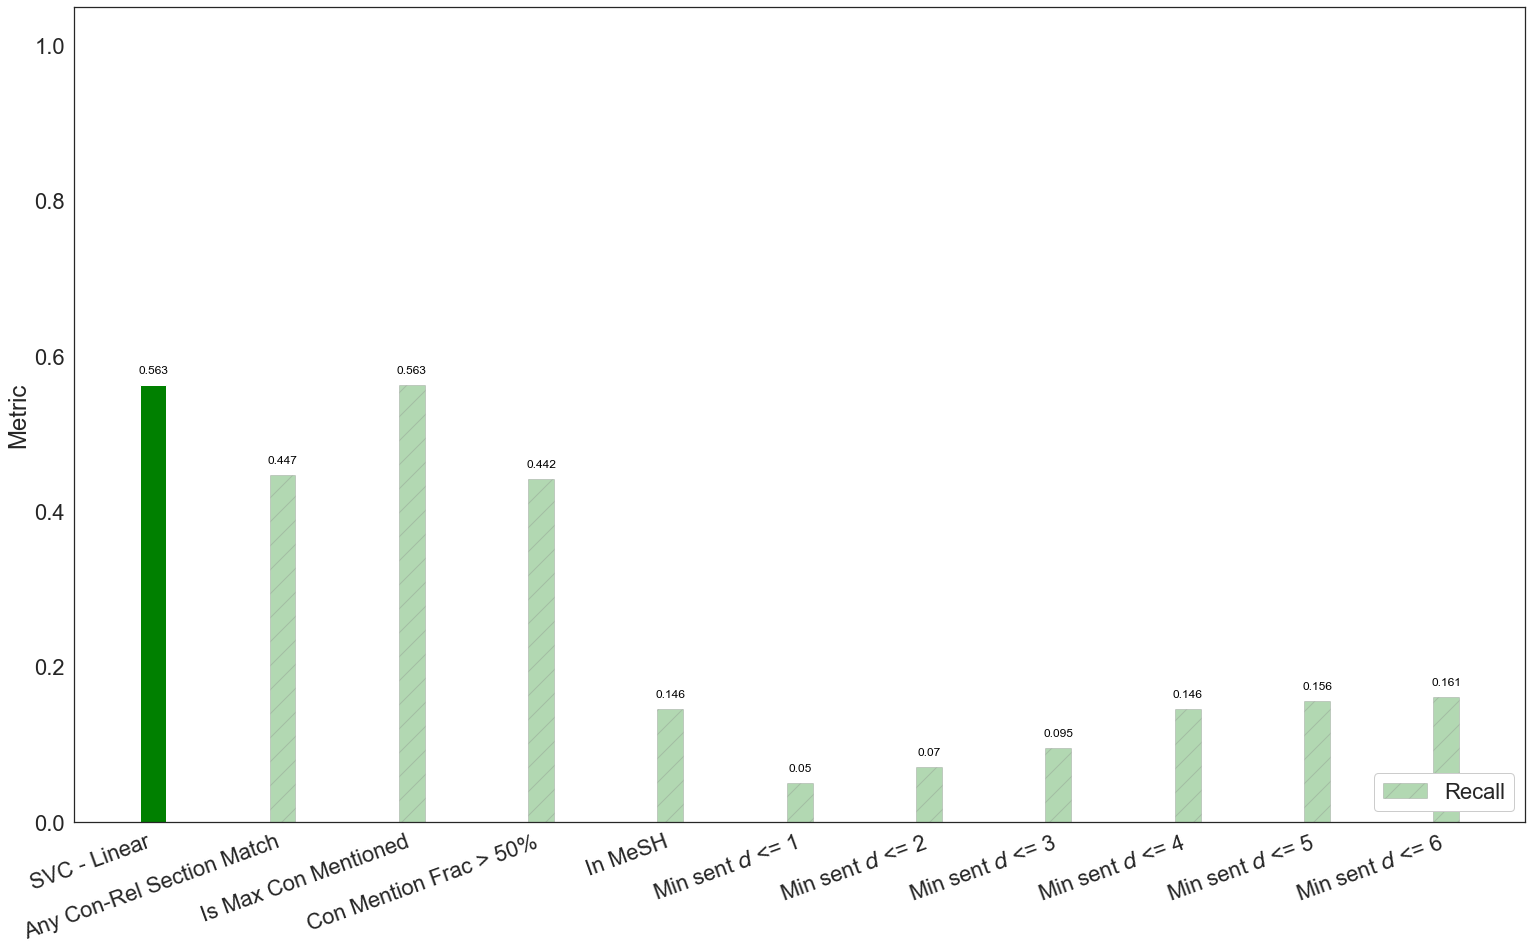

N negatives: 373
N positives: 199
Total len of resulting DF: 572


N negatives - after up/down-weighting: 199
N positives - after up/down-weighting: 199
Total len of resulting DF: 398
norm_rel_sec_title not found in column list. Assigning it a column of falses
norm_rel_sec_abstract not found in column list. Assigning it a column of falses
norm_rel_sec_methods not found in column list. Assigning it a column of falses
Initializing list of untrained models...
Fitting model: Logistic Reg
Fitting model: SVC - Linear
Fitting model: Random Forest
Fitting model: Feedforward Neural Net
Fitting model: Gradient Boosted Trees
Looking at clf: Logistic Reg
Accuracy 0.5714285714285714
Looking at clf: SVC - Linear
Accuracy 0.5639097744360902
Looking at clf: Random Forest
Accuracy 0.556390977443609
Looking at clf: Feedforward Neural Net
Accuracy 0.5639097744360902
Looking at clf: Gradient Boosted Trees
Accuracy 0.6015037593984962


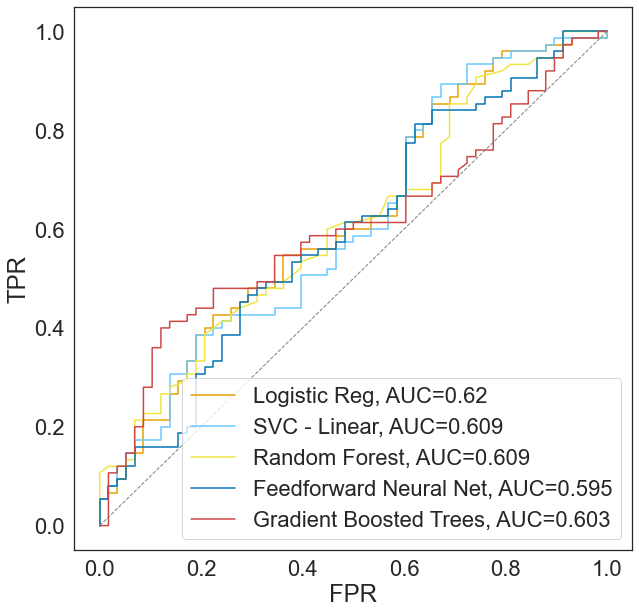

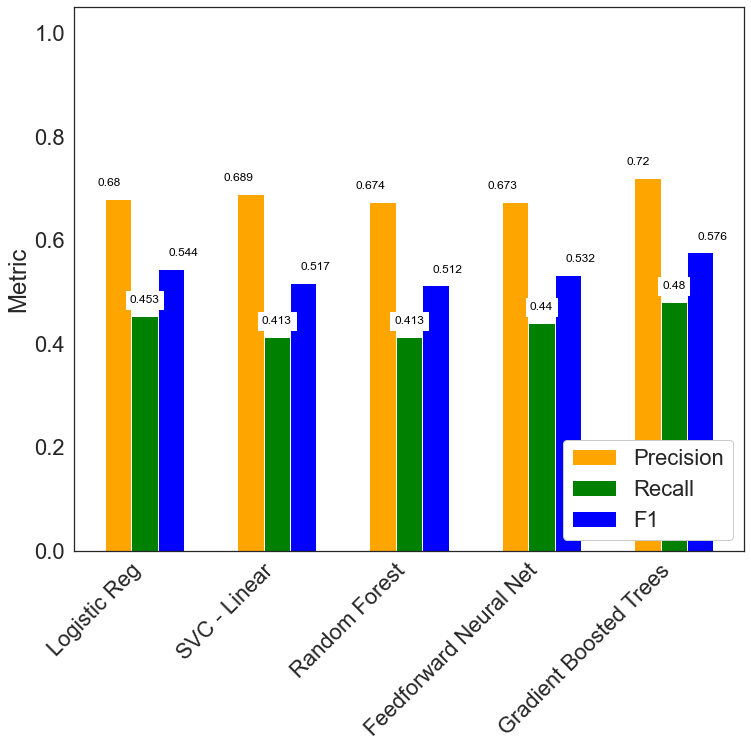

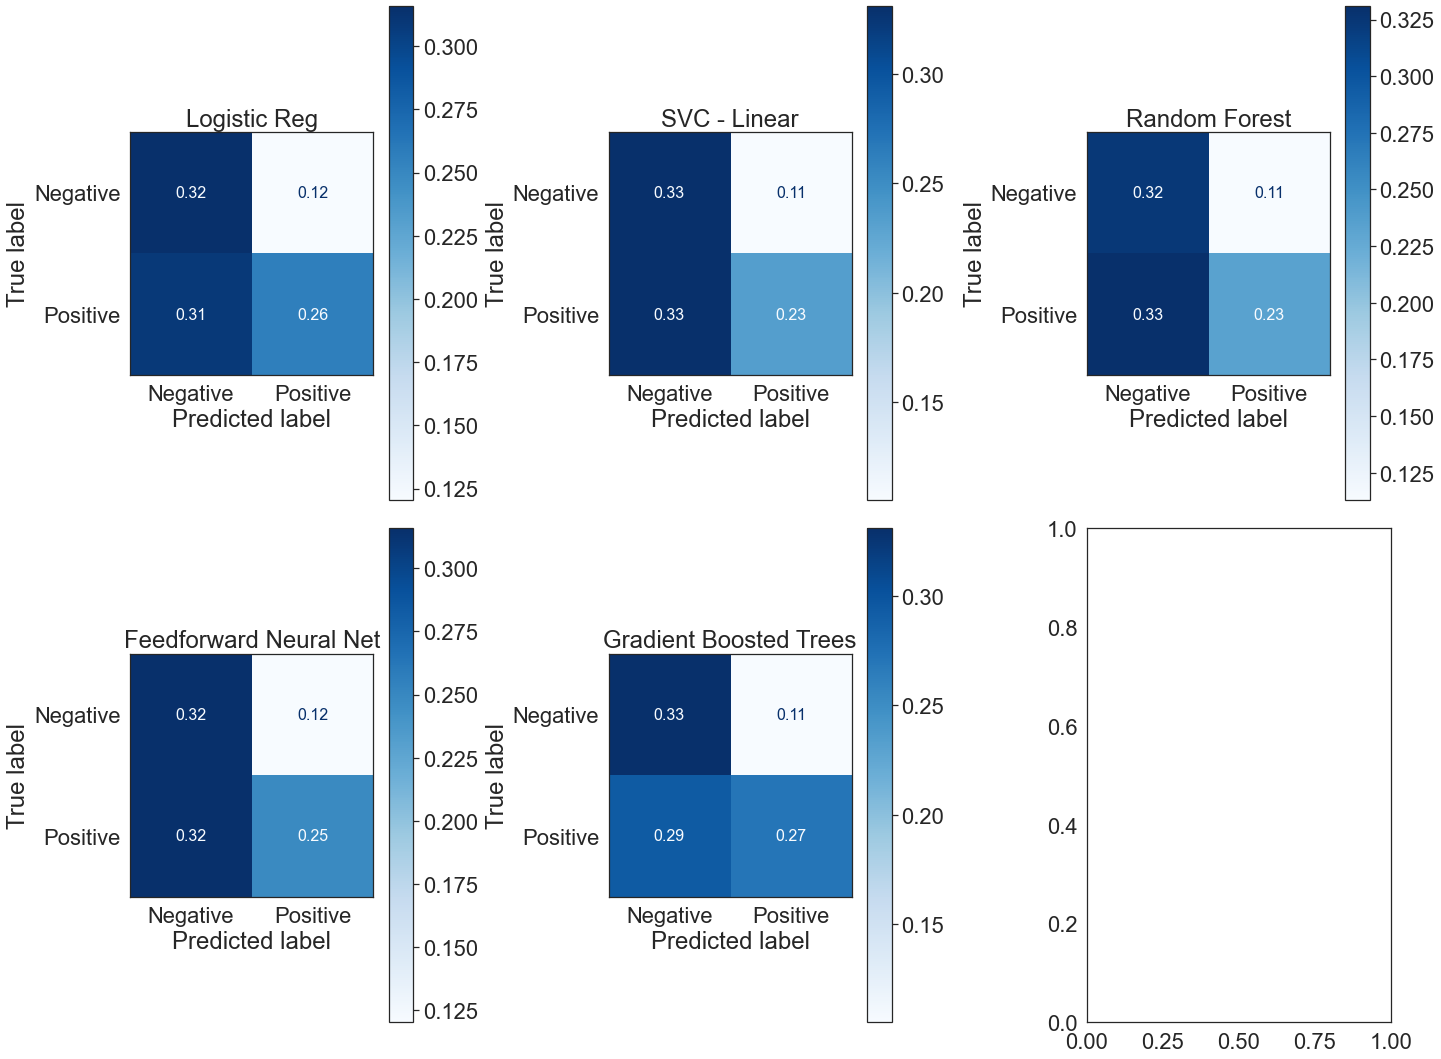

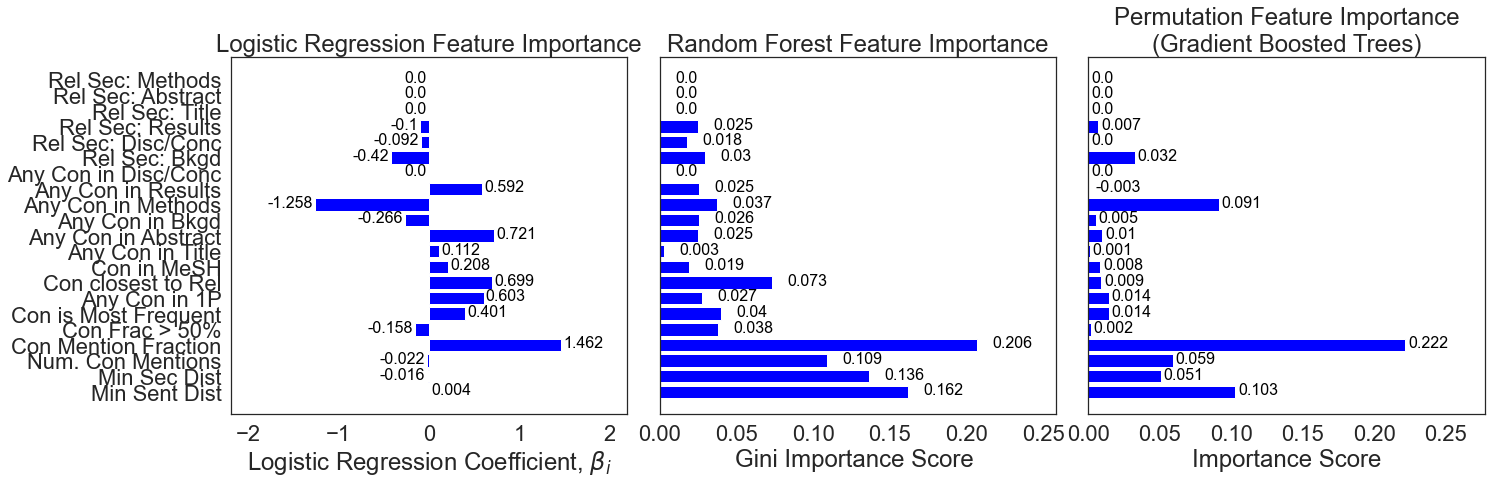

Looking at benchmark: any_rel_con_section_match
Accuracy 0.4623115577889447
Looking at benchmark: is_con_mention_max
Accuracy 0.6532663316582915
Looking at benchmark: con_mention_50
Accuracy 0.6482412060301508
Looking at benchmark: con_in_mesh_headings
Accuracy 0.5376884422110553
Looking at benchmark: min_sent_dist_1
Accuracy 0.507537688442211
Looking at benchmark: min_sent_dist_2
Accuracy 0.5100502512562815
Looking at benchmark: min_sent_dist_3
Accuracy 0.5175879396984925
Looking at benchmark: min_sent_dist_4
Accuracy 0.5301507537688442
Looking at benchmark: min_sent_dist_5
Accuracy 0.5150753768844221
Looking at benchmark: min_sent_dist_6
Accuracy 0.5125628140703518


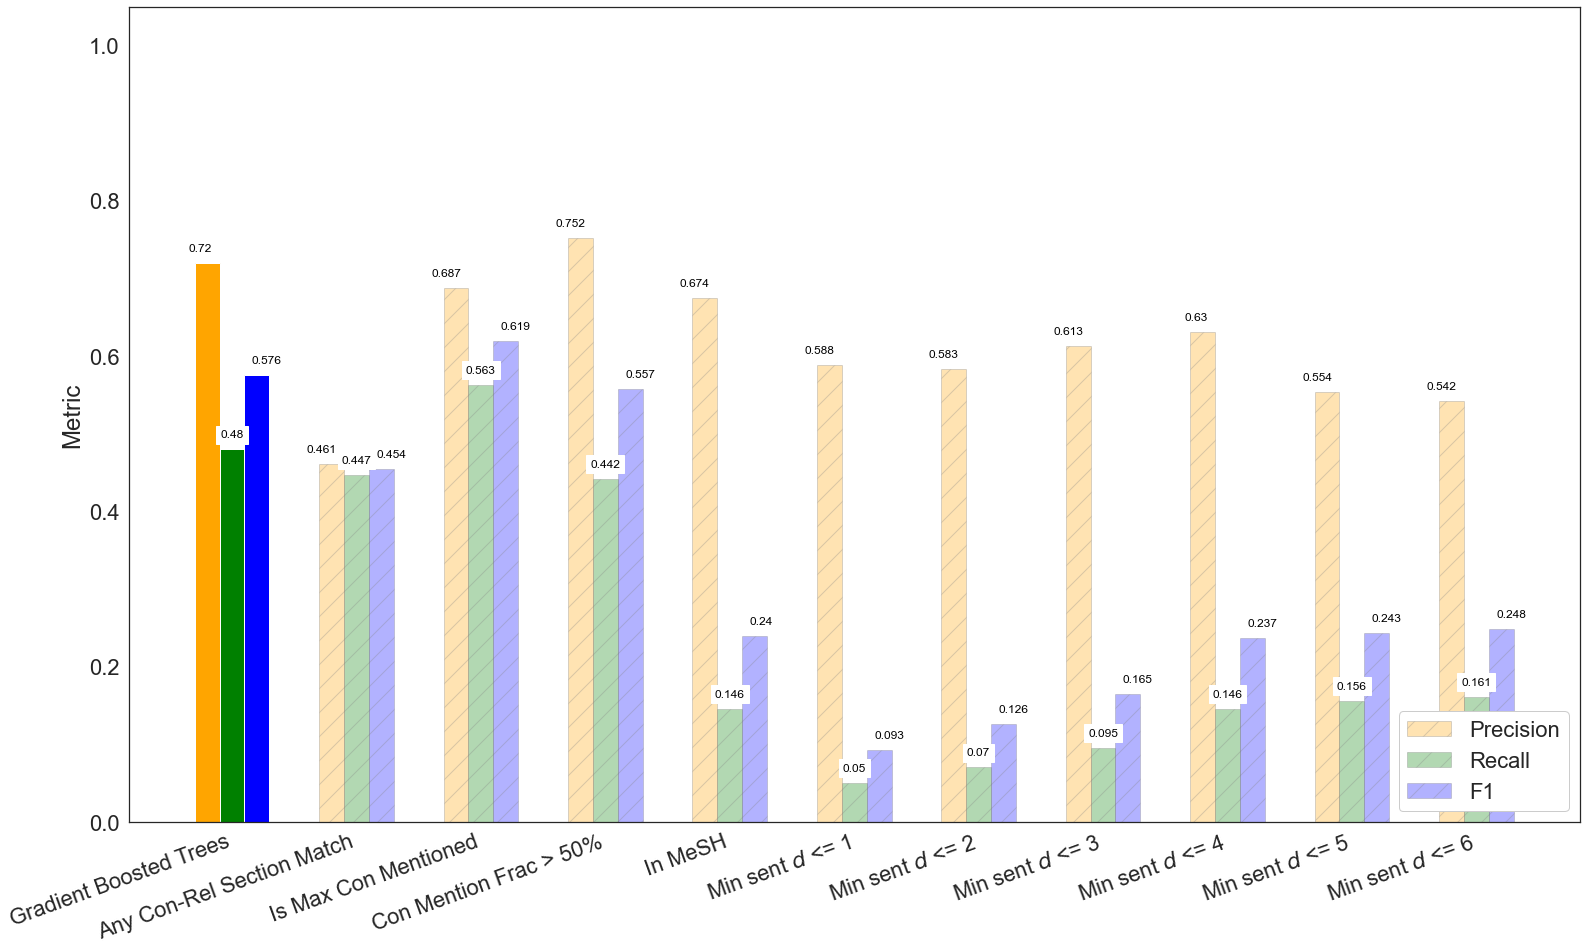

In [93]:
giant_res_df50NC_transfer, _, _ = generate_analysis_figs(giant_df_features_annots50NC, 
                                                grouped_analysis=True,
                                                downsample_maj=False,
                                                upsample_min=False,
                                                weight_imbalance=False,
                                                in_clf_list=insider_CT_clf_list,
                                                plot_roc_curve=True,
                                                plot_confusion_matrices=True,
                                                plot_feature_analysis=False,
                                                recall_only=True,
                                                out_dir=fig_out_dir,
                                                filename="giantTransfer50NC")


plot_benchmark_fig(giant_res_df50NC_transfer, 
                  best_model_name="SVC - Linear", 
                  best_model_stats=[.563],
                  recall_only=True,
                  out_dir=fig_out_dir,
                  filename="giantTransfer50NC")

giant_res_df50NC_retrain, _, _ = generate_analysis_figs(giant_df_features_annots50NC, 
                                                grouped_analysis=True,
                                                downsample_maj=True,
                                                upsample_min=False,
                                                weight_imbalance=False,
                                                plot_roc_curve=True,
                                                plot_confusion_matrices=True,
                                                plot_feature_analysis=True,
                                                recall_only=False,
                                                out_dir=fig_out_dir,
                                                filename="giantRetrain50NC")

plot_benchmark_fig(giant_res_df50NC_retrain, 
                   best_model_name="Gradient Boosted Trees", 
                   best_model_stats=[.720, .480, .576],
                   out_dir=fig_out_dir,
                   filename="giantRetrain50NC")

In [37]:
giant_res_df[giant_res_df.rel == 'WT1 induces the expression of amphiregulin, which is secreted by the metanephric mesenchyme to stimulate the growth of the ureteric tree ( 3 ).']


rel  \
0  WT1 induces the expression of amphiregulin, which is secreted by the metanephric mesenchyme to stimulate the growth of the ureteric tree ( 3 ).   
2  WT1 induces the expression of amphiregulin, which is secreted by the metanephric mesenchyme to stimulate the growth of the ureteric tree ( 3 ).   
4  WT1 induces the expression of amphiregulin, which is secreted by the metanephric mesenchyme to stimulate the growth of the ureteric tree ( 3 ).   

           con  min_sent_dist  min_sec_dist  num_con_mentions  \
0       kidney            8.0           1.0                 5   
2  vasculature            1.0           0.0                 1   
4         lung            8.0           1.0                 1   

   con_mention_frac  con_mention_50  is_con_mention_max  any_con_fp  \
0          0.714286            True                True       False   
2          0.142857           False               False       False   
4          0.142857           False               False       False   

   is_closest_cont_by_sent  con_in_mesh_headings norm_rel_sec  any_con_title  \
0                    False                     0   background          False   
2                     True                     0   background          False   
4                    False                     0   background          False   

   any_con_abstract  any_con_background  any_con_methods  any_con_results  \
0             False                True            False             True   
2             False                True            False            False   
4             False                True            False            False   

   any_con_disc_conc  annotation  any_rel_con_section_match  min_sent_dist_1  \
0              False       False                       True            False   
2              False       False                       True             True   
4              False        True                       True            False   

   min_sent_dist_2  min_sent_dist_3  min_sent_dist_4  min_sent_dist_5  \
0            False            False            False            False   
2             True             True             True             True   
4            False            False            False            False   

   min_sent_dist_6  
0            False  
2             True  
4            False

In [43]:
sent = "In HuH-28 cells, leptin increased STAT3 and ERK1/2 phosphorylation."

giant_res_df[giant_res_df.rel == sent]

rel  \
7  In HuH-28 cells, leptin increased STAT3 and ERK1/2 phosphorylation.   
9  In HuH-28 cells, leptin increased STAT3 and ERK1/2 phosphorylation.   

              con  min_sent_dist  min_sec_dist  num_con_mentions  \
7  adipose tissue          105.0          31.0                 2   
9           liver           25.0           5.0                27   

   con_mention_frac  con_mention_50  is_con_mention_max  any_con_fp  \
7          0.068966           False               False       False   
9          0.931034            True                True        True   

   is_closest_cont_by_sent  con_in_mesh_headings norm_rel_sec  any_con_title  \
7                    False                     0      results          False   
9                     True                     0      results          False   

   any_con_abstract  any_con_background  any_con_methods  any_con_results  \
7             False                True            False            False   
9             False               False             True             True   

   any_con_disc_conc  annotation  any_rel_con_section_match  min_sent_dist_1  \
7              False        True                      False            False   
9              False       False                       True            False   

   min_sent_dist_2  min_sent_dist_3  min_sent_dist_4  min_sent_dist_5  \
7            False            False            False            False   
9            False            False            False            False   

   min_sent_dist_6  
7            False  
9            False

In [44]:
sent = "As predicted, the MEK/ERK inhibitor U1026 and the pKa inhibitor H89 each attenuated the induction of PPARδ ( Fig. 2B ) and phospho-Rb (unpublished data) by EGF and TSH treatment, respectively."

giant_res_df[giant_res_df.rel == sent]

rel  \
169  As predicted, the MEK/ERK inhibitor U1026 and the pKa inhibitor H89 each attenuated the induction of PPARδ ( Fig. 2B ) and phospho-Rb (unpublished data) by EGF and TSH treatment, respectively.   
171  As predicted, the MEK/ERK inhibitor U1026 and the pKa inhibitor H89 each attenuated the induction of PPARδ ( Fig. 2B ) and phospho-Rb (unpublished data) by EGF and TSH treatment, respectively.   
175  As predicted, the MEK/ERK inhibitor U1026 and the pKa inhibitor H89 each attenuated the induction of PPARδ ( Fig. 2B ) and phospho-Rb (unpublished data) by EGF and TSH treatment, respectively.   
179  As predicted, the MEK/ERK inhibitor U1026 and the pKa inhibitor H89 each attenuated the induction of PPARδ ( Fig. 2B ) and phospho-Rb (unpublished data) by EGF and TSH treatment, respectively.   

                con  min_sent_dist  min_sec_dist  num_con_mentions  \
169           liver          108.0          28.0                 1   
171          kidney           14.0           3.0                 3   
175  adipose tissue           18.0           4.0                 1   
179            lung           60.0          15.0                 1   

     con_mention_frac  con_mention_50  is_con_mention_max  any_con_fp  \
169          0.166667           False               False       False   
171          0.500000            True                True       False   
175          0.166667           False               False       False   
179          0.166667           False               False       False   

     is_closest_cont_by_sent  con_in_mesh_headings norm_rel_sec  \
169                    False                     0      results   
171                     True                     0      results   
175                    False                     0      results   
179                    False                     0      results   

     any_con_title  any_con_abstract  any_con_background  any_con_methods  \
169          False             False                True            False   
171          False             False                True             True   
175          False             False               False            False   
179          False             False               False            False   

     any_con_results  any_con_disc_conc  annotation  \
169            False              False       False   
171             True              False       False   
175             True              False        True   
179            False              False        True   

     any_rel_con_section_match  min_sent_dist_1  min_sent_dist_2  \
169                      False            False            False   
171                       True            False            False   
175                       True            False            False   
179                      False            False            False   

     min_sent_dist_3  min_sent_dist_4  min_sent_dist_5  min_sent_dist_6  
169            False            False            False            False  
171            False            False            False            False  
175            False            False            False            False  
179            False            False            False            False

Thoughts
- PMC2587040: kidney is the main tissue of focus here. But the interaction is likely present in lung similar mechanism (don't know about amphiregulin and lung based on this paper). Can't conclude that this is a true association based on this paper. Kidney is a false negative.

##### Final thoughts:
Associations that I make (positive) are higher GIANT confidence than negative associations.....?

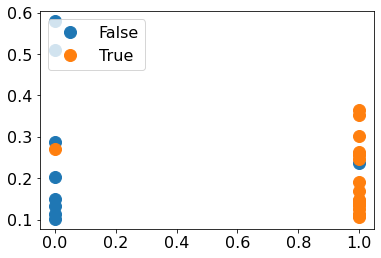

In [85]:
# Generate Data
#num = 20
#x, y = np.random.random((2, num))
#labels = np.random.choice(['a', 'b', 'c'], num)
#df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = xx.groupby('Label')

# Plot
#plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
#colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')

fig, ax = plt.subplots()
#ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Pred: Random Forest'], group.Conf, marker='o', linestyle='', ms=12, label=name)
ax.legend(numpoints=1, loc='upper left')

plt.show()

#### Dengue analyses

In [98]:
insider_df_CTs.head()

Extracted Relation  \
0                                                                                                          Our findings indicate that TREM-1 expression is up-regulated by NLRP3 inflammasome through ROS-NF-κB signaling in macrophages.   
1  Thus, the evidence that A-FABP enhances the expression of MMP-9 (and its activity) in macrophages suggests that the effect of elevated levels of the latter on plaque rupture is attributable to the increased presence of the former.   
2                        IGF-1 also decreases expression of lipoprotein lipase (LPL) in macrophages (LPL facilitates uptake of modified LDL) and increases expression of endothelial nitric oxide synthase (eNOS) and phosphorylated Akt.   
3                                                             In fact, in cardiac muscle cells, c-Ski expression is downregulated by TGF-β and c-Ski gene silencing aggravates the fibrogenic transformation process stimulated by TGF-β.   
4                           The treatment with anti-CCL2 antibody significantly suppressed Ccl3 transcript levels in MAMs ( Fig. 2 C ), indicating that CCL2 can increase CCL3 expression in macrophages at the metastasis sites as well.   

               Context  \
0           macrophage   
1           macrophage   
2           macrophage   
3  cardiac muscle cell   
4           macrophage   

                                                                                                                                                                                                                                         All Tabula Contexts in Paper  \
0                                                                                                                                                                                                                                        ['neutrophil', 'macrophage']   
1                                                                                                                                                                                                                  ['macrophage', 'smooth muscle cell', 'neutrophil']   
2                                                                                                                                                                                                       ['platelet', 'leukocyte', 'macrophage', 'smooth muscle cell']   
3  ['hepatocyte', 'smooth muscle cell', 'keratocyte', 'leukocyte', 'keratinocyte', 'cardiac fibroblast', 'fat cell', 'platelet', 'cardiac muscle cell', 'stromal cell', 'neutrophil', 'secretory cell', 'retinal pigment epithelial cell', 'macrophage', 'mast cell']   
4                                                                                                                                                                                                           ['leukocyte', 'stromal cell', 'macrophage', 'neutrophil']   

        PMCID Entity 1 Text       Entity 2 Text  Citation Dist  
0  PMC7545267        TREM-1               NLRP3            1.0  
1  PMC7556749        A-FABP               MMP-9            1.0  
2  PMC2848911         IGF-1  lipoprotein lipase            NaN  
3  PMC7779530         c-Ski               TGF-β            1.0  
4  PMC4493415          CCL2                CCL3            3.0

Gene1   Gene2  Gene1_Entrez  Gene2_Entrez combined_entities_key
1   DMBX1    IRF1        127343          3659           127343_3659
3   DMBX1   RPE65        127343          6121           127343_6121
4   DMBX1   NR4A2        127343          4929           127343_4929
5  ADAM10  ADAM17           102          6868              102_6868
6  ADAM10     IL6           102          3569              102_3569

In [142]:
dengue_ppis_df = create_dengue_corpus()
print(f"Input: {len(dengue_ppis_df)} dengue-related PPIs")
dengue_relations_df = dl.get_relation_subset_from_ppi_intersect(subset_df=dengue_ppis_df)
print(f"From this list found {len(dengue_relations_df)} dengue relations")

dengue_features_df_path = "/Users/dnsosa/Desktop/AltmanLab/bai/Stanford-Collab/output/dengue_papers_features_df.tsv"
dengue_features_df = pd.read_csv(dengue_features_df_path, sep='\t')

dengue_features_df['annotation'] = False
# Dengue DF
# Transferred model

# This is a hacky way to get at predictions. Should just design this better.
_, _, dengue_predictions_df = generate_analysis_figs(dengue_features_df, 
                       grouped_analysis=True,
                       downsample_maj=False,
                       upsample_min=False,
                       weight_imbalance=False,
                       in_clf_list=insider_CT_clf_list,
                       plot_roc_curve=True,
                       plot_confusion_matrices=False,
                       plot_feature_analysis=False,
                       in_loc="upper right")

Dengue_pps_df network has: 89971 directed edges
There are: 5853 unique genes in this network
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5853...done.
Finished.
1 input query terms found dup hits:
	[('FCGR2C', 2)]
22 input query terms found no hit:
	['DDX58', 'ARNTL', 'CYHR1', 'MT-ND3', 'MT-ND2', 'CLECL1', 'MT-ND5', 'MYLPF', 'MT-CO2', 'UHRF1BP1L', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
Retrieved a mapping from Entrez to gene symbols
Input: 88774 dengue-related PPIs
After taking subset of relations, need to extract features from: 8787 papers
From this list found 11674 dengue relations
N negatives: 12470
N positives: 0
Total len of resulting DF: 12470


N negatives - after up/down-weighting: 12470
N positives - after up/down-weighting: 0
Total len of resulting DF: 12470
List of 5 pre-trained models provided. No need to initialize new models.
L

/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dnsosa/opt/miniconda3/envs/lit_con2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

<Figure size 720x720 with 0 Axes>

In [145]:
dengue_relations_df_small = dengue_relations_df[["rel", "entity1_text", "entity2_text", "entity1_entrez", "entity2_entrez"]]

col_list = ["rel", "entity1_text", "entity2_text", "entity1_entrez", "entity2_entrez", "con", "Pred: Random Forest"]
dengue_conned_rels_df = dengue_predictions_df.merge(dengue_relations_df_small, on="rel", how="inner")[col_list]

dengue_edgelist = dengue_conned_rels_df[dengue_conned_rels_df["Pred: Random Forest"]]
print(f"The random forest transferred from the Insider CT training yielded: {len(dengue_edgelist)} context associations")
for in_con in ["macrophage", "hepatocyte", "neutrophil"]:
    print(f"...{len(dengue_edgelist[dengue_edgelist.con == in_con])} from {in_con}")
    
dengue_edgelist.head(5)


The random forest transferred from the Insider CT training yielded: 4400 context associations
...1577 from macrophage
...466 from hepatocyte
...270 from neutrophil


rel  \
0   Treatment with anti-IL5 antibody, that reduced the number of submucosal eosinophils in patients with asthma, was associated with a reduction in TGF-β levels in bronchoalveolar lavage fluid 34 , indicating that TGF-β may be induced by IL-5.   
3                                                                        These results indicate that IL-18 enhances YY1 expression via NF-κB, leading to the repression of FXR expression by elevated YY1, resulting in reduced of MRP2 expression.   
7                                                                                               In order to detect whether type I IFN (IFN-α/β) can induce ATX expression directly, the THP-1 cells were treated with IFN-α and IFN-β respectively.   
9       ATX expression was induced quickly by IFN-α, peaked at 2h of treatment and then decreased, while during IFN-β treatment ATX expression was increased continually, achieved high levels after 8h treatment and then kept at the high levels.   
11                                                                                                                                      A PPAR γ antagonist increased eNOS expression in adipocytes and suppressed HFD-induced fatty liver changes.   

   entity1_text entity2_text entity1_entrez entity2_entrez         con  \
0         TGF-β         IL-5          27035          50507  neutrophil   
3         IL-18          YY1            183           2597  hepatocyte   
7           IFN          ATX           3553           3606  macrophage   
9           ATX        IFN-α            728           3605  macrophage   
11       PPAR γ         eNOS            930           4907  hepatocyte   

    Pred: Random Forest  
0                  True  
3                  True  
7                  True  
9                  True  
11                 True

In [153]:
def plot_mac_hep_neu_venn(dengue_edgelist, fig_out_dir, dpi=300):
    plt.rcParams["figure.figsize"] = (20, 20)

    font = {'family': 'normal',
            'size': 32}

    matplotlib.rc('font', **font)

    mac_set = set(dengue_edgelist[dengue_edgelist.con == 'macrophage'][["entity1_entrez", "entity2_entrez"]].itertuples(
        index=False, name=None))
    hep_set = set(dengue_edgelist[dengue_edgelist.con == 'hepatocyte'][["entity1_entrez", "entity2_entrez"]].itertuples(
        index=False, name=None))
    neu_set = set(dengue_edgelist[dengue_edgelist.con == 'neutrophil'][["entity1_entrez", "entity2_entrez"]].itertuples(
        index=False, name=None))

    mac_only = mac_set.difference(hep_set.union(neu_set))
    hep_only = hep_set.difference(mac_set.union(neu_set))
    neu_only = neu_set.difference(mac_set.union(hep_set))

    mac_hep = mac_set.intersection(hep_set).difference(neu_set)
    mac_neu = mac_set.intersection(neu_set).difference(hep_set)
    neu_hep = neu_set.intersection(hep_set).difference(mac_set)

    all_three = mac_set.intersection(hep_set).intersection(neu_set)

    # Make the diagram
    venn3(subsets=(len(mac_only), len(hep_only), len(mac_hep),
                   len(neu_only), len(mac_neu), len(neu_hep),
                   len(all_three)),
          set_labels=('Macrophage', 'Hepatocyte', 'Neutrophil'))

    out_file = os.path.join(fig_out_dir, f"Dengue3CTVenn.png")
    plt.savefig(out_file, dpi=dpi, bbox_inches="tight")

    plt.show()

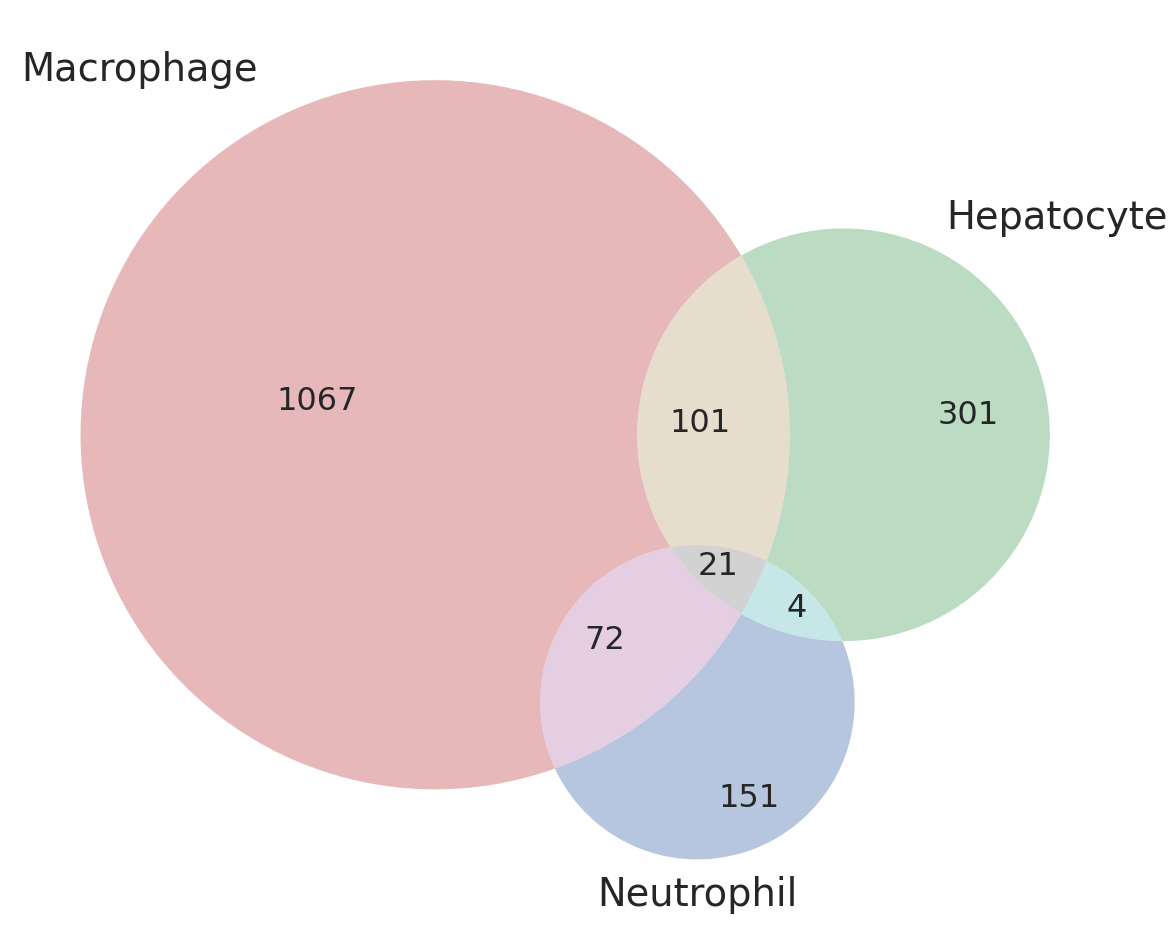

In [154]:
plot_mac_hep_neu_venn(dengue_edgelist, fig_out_dir, dpi=300)

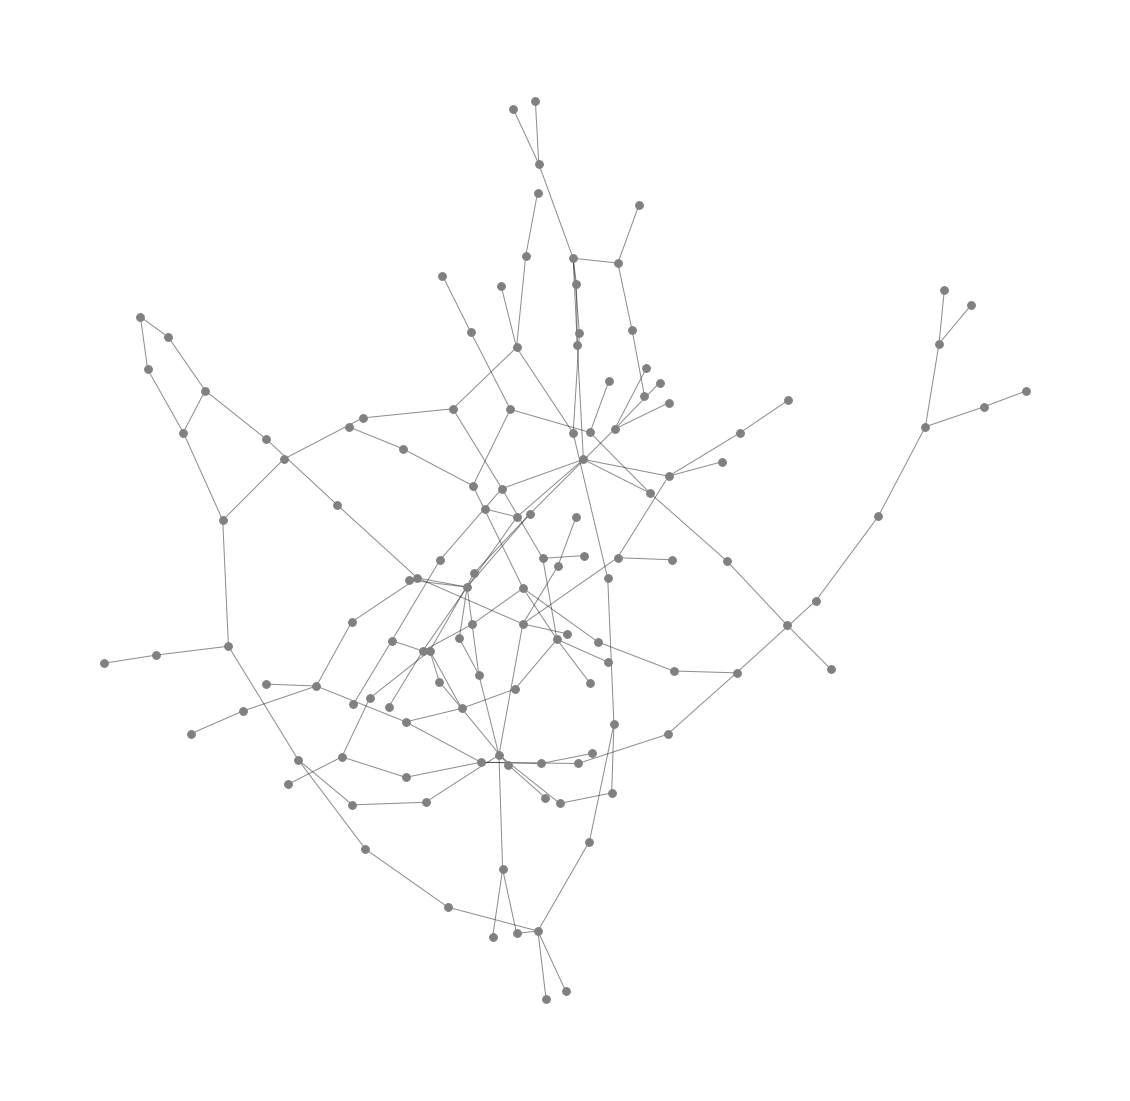

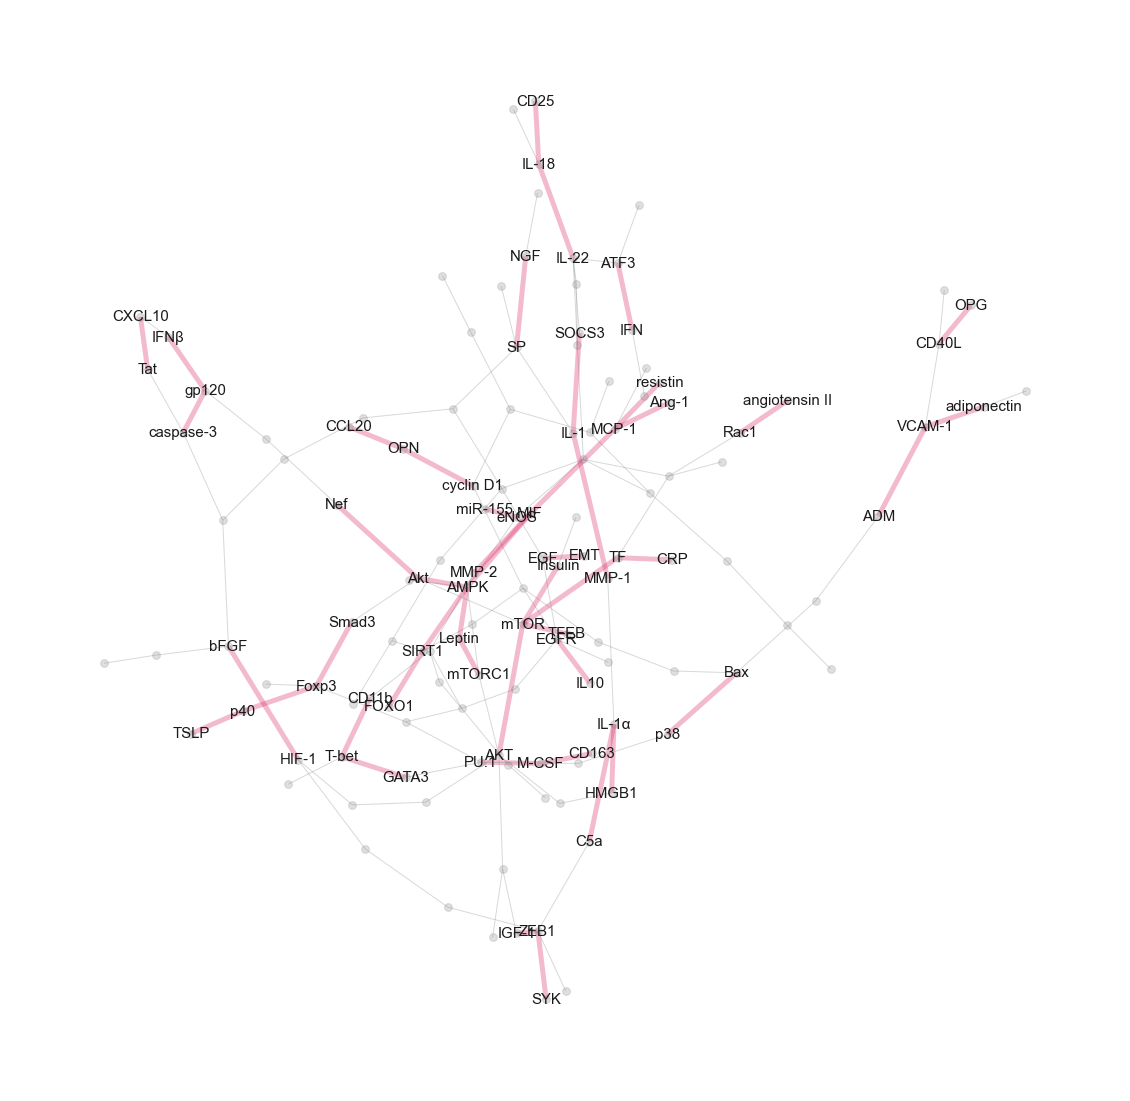

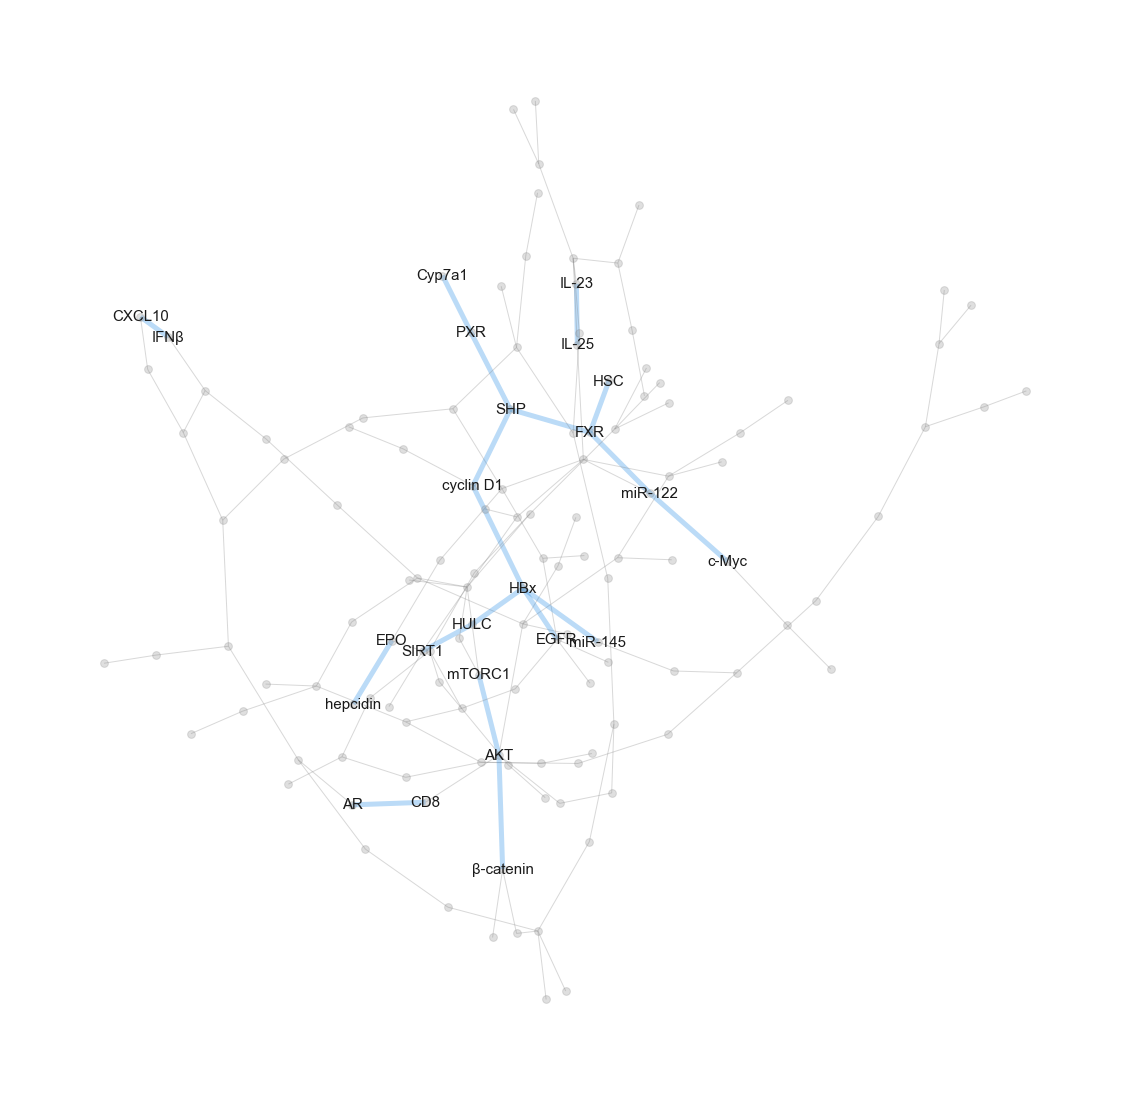

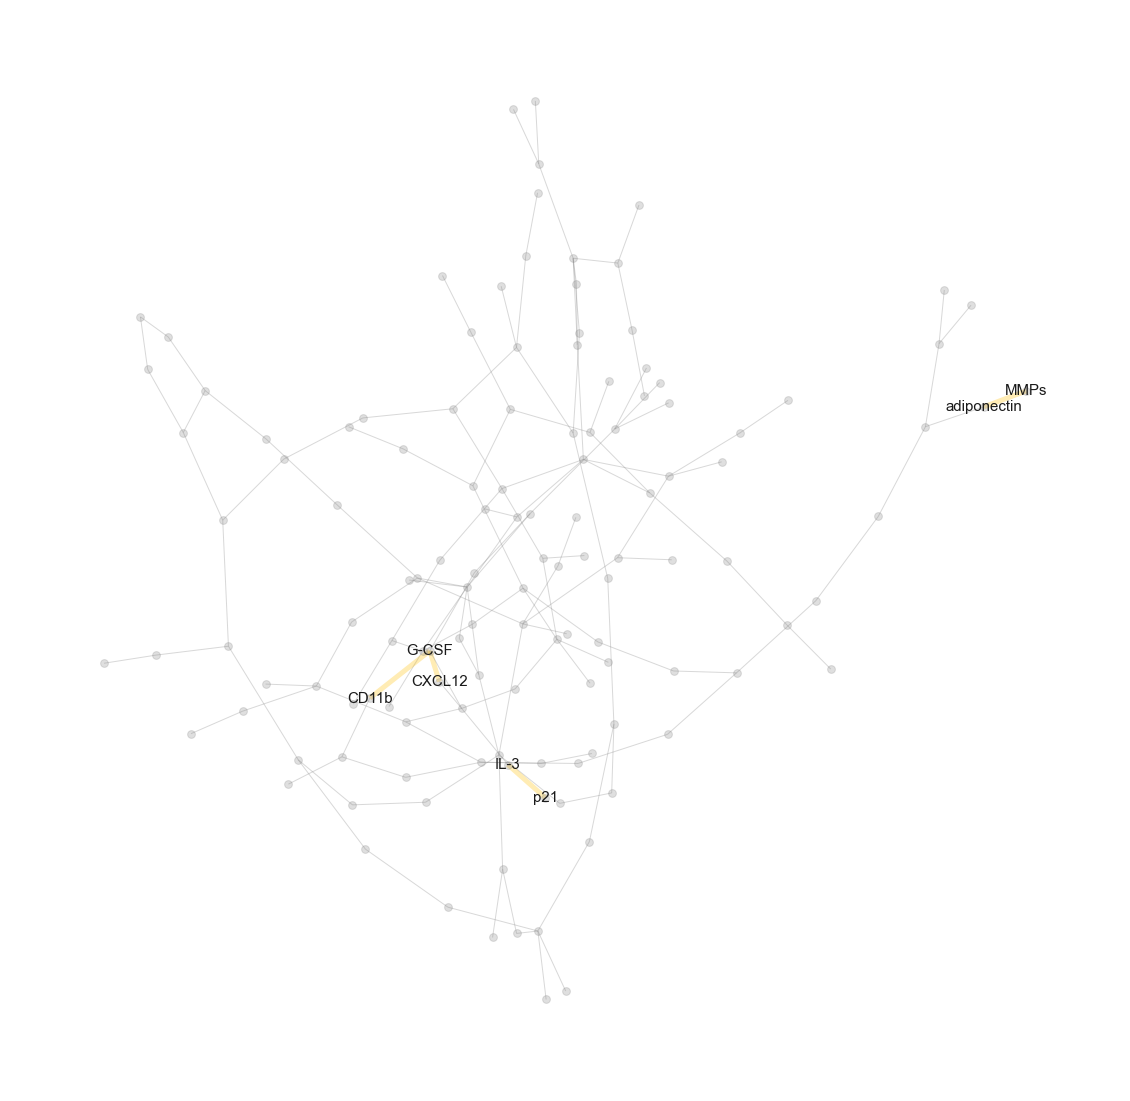

In [139]:
plot_dengue_networks(dengue_edgelist, fig_out_dir)

#### Misc Graveyard

In [ ]:
# Separating out the tissues and CTs in ENA. Too few!

onto2texts, text2ontos = load_all_groundings()

# CTs
onto2texts_CTs = {k:onto2texts[k] for k in onto2texts if "uaz:CL" in k}
ena_CTs = set()
for CT in onto2texts_CTs:
    ena_CTs = ena_CTs.union(set(onto2texts_CTs[CT]))
    
ena_CT_list_df = pd.DataFrame({"con": list(ena_CTs)})

# Tissues
onto2texts_tissues = {k:onto2texts[k] for k in onto2texts if "tissuelist:TS" in k}
ena_tissues = set()
for tissue in onto2texts_tissues:
    ena_tissues = ena_tissues.union(set(onto2texts_tissues[tissue]))
    
ena_tissue_list_df = pd.DataFrame({"con": list(ena_tissues)})

ena_df_CT_subset = ena_df.merge(ena_CT_list_df, on="con", how="inner")
print(len(ena_df_CT_subset))
print(set(ena_df_CT_subset.con))

ena_df_tissue_subset = ena_df.merge(ena_tissue_list_df, on="con", how="inner")
print(len(ena_df_tissue_subset))
print(set(ena_df_tissue_subset.con))


In [ ]:
# ena_df_CT_res = generate_analysis_figs(ena_df_CT_subset, 
#                        grouped_analysis=True,
#                        downsample_maj=False,
#                        upsample_min=False,
#                        weight_imbalance=False,
#                        in_clf_list=insider_CT_clf_list,
#                        plot_roc_curve=True,
#                        plot_confusion_matrices=True,
#                        plot_feature_analysis=False,
#                        in_loc="upper right")
# 
# ena_df_tissue_res = generate_analysis_figs(ena_df_tissue_subset, 
#                        grouped_analysis=True,
#                        downsample_maj=False,
#                        upsample_min=False,
#                        weight_imbalance=False,
#                        in_clf_list=insider_CT_clf_list,
#                        plot_roc_curve=True,
#                        plot_confusion_matrices=True,
#                        plot_feature_analysis=False,
#                        in_loc="upper right")